Son güncelleme: **02.06.2022**

**NOTLAR:**

- Görsellerin bir kısmı değerli hocam Sait Ölmez'in(Sabancı Üniversitesi) sunumlarından bir kısmı da internetten çeşitli kaynaklardan alınmıştır.
- Verdiğim linkler çalışmıyorsa lütfen benle iletişime geçin: volkan.yurtseven@hotmail.com
- Benim python ayarlarım startup olarak magic ve extension fonksiyonlarımı otomatik yüklüyor. Nelerin yüklendiğini görmek ve sizde de benzer çıktıların oluşmasını sağlamak için <a href="https://mvolkanyurtseven.medium.com/top-n-useful-python-tips-tricks-e3a163e56749">buraya</a> bakınız. Burada **extension methods** ve **magic functions** maddelerine bakınız. Bunlar çok faydalı özellikler olup, aynı zamanda bu notebookun hatasız çalışması için de gereklidir. Benim anlattığım şekilde kurmayı başaramazsanız bile, ilgili kodları alıp bu notebookun başına yapıştırsanız da olur.
- Bu notebookta ML sürecinin detaylarına odaklanacağız. Biraz uzun, hatta çok uzun bir notebook olacak. Çünkü tüm ML conceptelerinin detayını burda vermeye çalışacağım. Bununla beraber tüm anlatılacak conceptlere uygun bir dataseti bulmak oldukça zor olduğu için yer yer başka notebooklara linkler vereceğim.
- Bu notebooktaki ana amacımız conceptleri vermeye çalışmak olacak; en iyi modeli kurmaya çalışmak değil. Eminim biraz daha uğraştığınızda burdakinden daha iyi sonuçlar veren bir model kurabilirsiniz.
- Dosya çok daha büyük olmasın diye AutoEDA araçlarını(Dataprep, pandas-profiling v.s) da kullanmayacağız.
- NOT:Dosya yine de çok büyük oldu(nbextensions aktifleşemeyecek ve sol panelde TOC görünmeyecek kadar büyüdü), o yüzden **`Part I ve Part II`** olmak üzere iki kısma ayrırdım. İlk kısımda Pipelinelara kadar olan olan bölümler, ikinci kısımda ise pipeline, model evaluation ve deployment bölümleri olacak.

# Modelleme öncesi

Öncelikle gerekli kütüphaneleri import edelim. Modellemeyle ilgili kütüphaneleri ise ileride yavaş yavaş dahil edeceğiz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [2]:
#kendi paketimi de yüklüyorum
from mypyext import dataanalysis as da
from mypyext import ml

all warnings will be shown


## Data temini

https://archive.ics.uci.edu/ml/datasets/heart+disease sayfasında detayları anlatılan veri setini kullanacağız. Devam etmeden önce buraya bakmanızı öneriyorum.

In [3]:
dfheart=pd.read_csv("https://raw.githubusercontent.com/VolkiTheDreamer/dataset/master/Classification/Heart.csv")
dfheart.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
len(dfheart)

303

## EDA

Öncelikle verisetimizi biraz keşfedelim, ne var ne yok, neler birbiriyle korele v.s bakalım

### Genel

In [5]:
dfheart.super_info_() #kendi yazdığım extension metodum. 

,Type,Nunique,#of Missing,MostFreqItem,MostFreqCount,First
Unnamed: 0,int64,303,0,1,1,1
Age,int64,41,0,58,19,63
Sex,int64,2,0,1,206,1
ChestPain,object,4,0,asymptomatic,144,typical
RestBP,int64,50,0,120,37,145
Chol,int64,152,0,204,6,233
Fbs,int64,2,0,0,258,1
RestECG,int64,3,0,0,151,2
MaxHR,int64,91,0,162,11,150
ExAng,int64,2,0,0,204,0


Bu extension metodların kullanım detayları için <a href="https://mvolkanyurtseven.medium.com/top-n-useful-python-tips-tricks-e3a163e56749">buraya</a> bakınız.

**Yorumlar**

- İlk kolon olan Unnamed:0 gereksiz, bunu sileceğiz.
- Son kolon AHD, target classımız, kişinin kalp hastalığı geçirip geçirmediğini söylüyor.
- Bir kategorik(Thal) bir de numerik(Ca) kolonda missing value var.
- Birkaç kolon numerik olmasına rağmen unique değer adedi çok küçük olduğu için bunların kategorik olarak ele alınması gerekecek. Ör:Sex 1:Male, 2:Female demekmiş

In [6]:
del dfheart["Unnamed: 0"]

<a href="https://en.wikipedia.org/wiki/Cardinality">Cardinalitesi</a> düşük olanlara bakalım.

In [7]:
da.getColumnsInLowCardinality(dfheart)

Unique items in column Sex
[1 0]

Unique items in column ChestPain
['typical' 'asymptomatic' 'nonanginal' 'nontypical']

Unique items in column Fbs
[1 0]

Unique items in column RestECG
[2 0 1]

Unique items in column ExAng
[0 1]

Unique items in column Slope
[3 2 1]

Unique items in column Ca
[ 0.  3.  2.  1. nan]

Unique items in column Thal
['fixed' 'normal' 'reversable' nan]

Unique items in column AHD
['No' 'Yes']

You may want to consider the numerics with low cardinality as categorical in the analysis


['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal', 'AHD']

- binaryler zaten aşikar, bunlar categoric olmalı.
- Dataset açıklamasında Chestpain için bi sıralamadan bahsetmiş, bunları ordinal veri olarak düşüneceğiz.
- Thal değeri için sıralama var mı emin değilim, bunu nominal alacağız.
- Ca: tanımda damar sayısı olarak verdiği için bunu categoric değil numeric olarak ele almak lazım, ama dikkat edelim ki imputation yaparken tam sayı değer olması gereken bu alana mean alma nedeniyle küsuratlı birşey gelmesin, o yüzden medianla imputation yapmak gerekecek. (Ben imputation gördüm, babamın imputationı var; merak etmeyin bunları sırayla göreceğiz)
- restecg: ordinal gibi duruyor.

Şimdi veri türlerimizi belirleyelim.

In [8]:
target=["AHD"]
nums=["Age","RestBP","Chol","MaxHR","Oldpeak","Ca"]
cats=list(dfheart.columns).removeItemsFromList_(nums+target,False) #extension metodum
ords=["ChestPain","RestECG"]
noms=cats.removeItemsFromList_(ords,False)

In [9]:
nums,cats,ords,noms

(['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak', 'Ca'],
 ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Thal'],
 ['ChestPain', 'RestECG'],
 ['Sex', 'Fbs', 'ExAng', 'Slope', 'Thal'])

### Visual

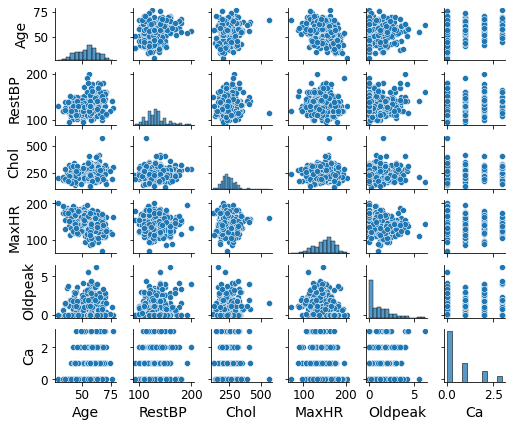

In [10]:
sns.pairplot(dfheart[nums],height=1, aspect=1.2);

- Oldpeak bayağı bi skewed görünüyor, sağ uçta biraz outlier da var. Chol'da da hafif bi skewness var ama o daha çok outlier gibi duruyor.
- Featurelar arasında pek bi korelasyon da yok gibi, multicollinearity problemimiz olmayacak.

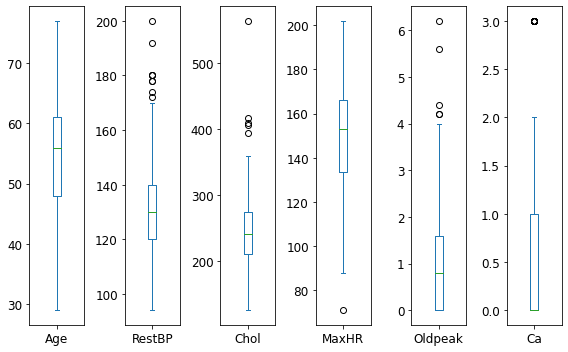

In [11]:
dfheart[nums].plot(kind="box", subplots = True,figsize=(8,5))
plt.tight_layout();

Pairplottaki gözlemimizi doğrulamış olduk, ancak pairplotta çok dikkat çekmeyen Restbps'de de outlierlar dikkat çekiyor

In [12]:
#mükerrer varmı
len(dfheart)-len(dfheart.duplicated(keep=False))

0

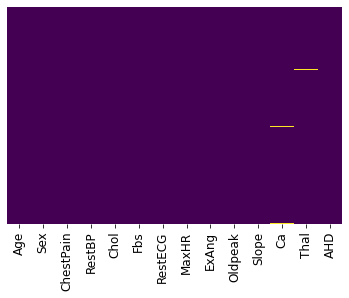

In [13]:
#nulların konumuna bakalım, yanyana mılar yoksa ayrı instancelardalar mı
da.nullPlot(dfheart)

Targetın dağılımına bakalım

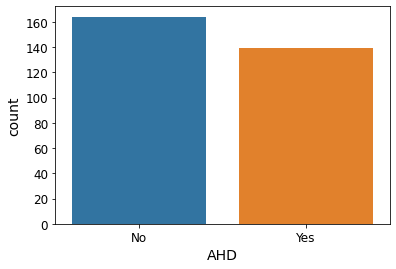

In [14]:
sns.countplot(x=dfheart["AHD"]);

Dengeli bir dağılım var gibi, imbalanced dataset problemimiz yok.

Target bazında numeriklerin ortalama değerlerine bakalım.

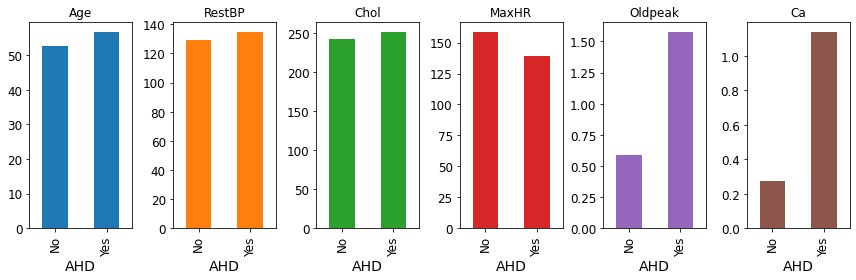

In [15]:
da.plotNumericsByTarget(dfheart,"AHD",nums=nums,layout=(1,6),figsize=(12, 4))

Oldpeak ve Ca, target bazında oldukça farkediyor, bunların feature importance'ı önemli olacak gibi duruyor. Korelasyon analizinde bu durumu muhtemelen teyit ederiz gibi.

Kategorik kolonlar üzerinden baktığımızda ilgili kategorilerdeki her bir değer için kalp hastalığına yakalanma olasılıklarına(prior probability) bakalım.

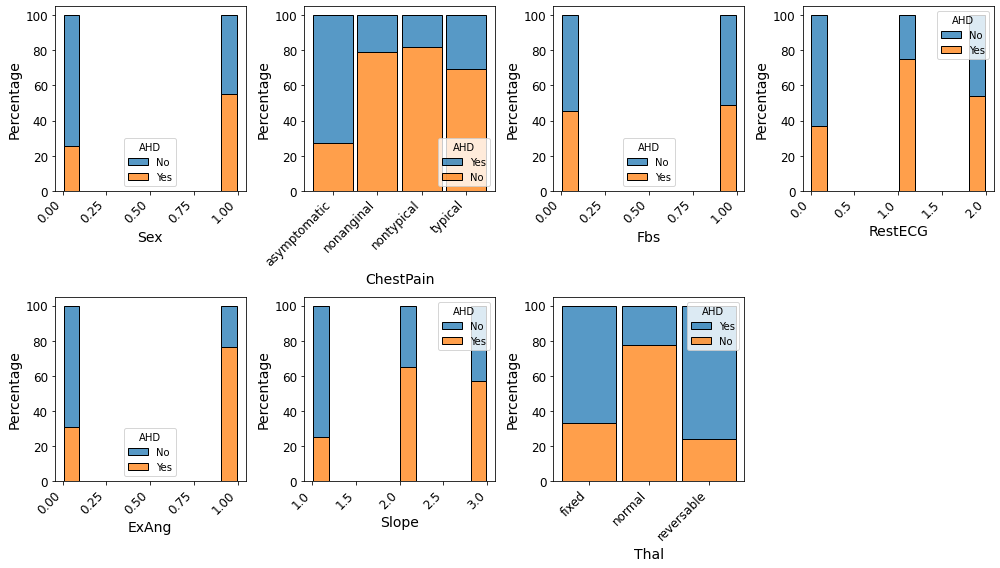

In [16]:
plt.figure(figsize=(14,8))
da.plotTargetByCats(dfheart, cats, "AHD", subplot_tpl=(2,4));

Bu grafikleri şöyle okumak lazım. Öncelikle bunların percentage olduğunu unutmayın:

- Kadınlarda(0) risk daha düşük, erkeklerde belirgin bir yükseklik/düşüklük yok.
- Göğüs ağrısı asemptomatik dışındaki olanlarda risk düşük.
- fbs için belirgin bir risklilik durumu yok
- RestECG ortadaki değerde risk yüksek ama biz buna ordinal demiştik, çok da emin olamadım açıkçası, biz yine de ordinal gibi davranalım buna.
- Ex Ang=1 olanlarda risk yüksek, 0 olanlarda düşük
- Slope'u 1 yani up olanlarda risk düşük, 2-flat olanlarda yüksek
- Thal'i normal olanlarda kalp hastalığı olma riski olmamasına göre daha düşük. reversible ve fixed olanlarda ise risk yüksek. Ama bu demek değil ki en çok hasatlık sahibi olanlar Thal'i reversible ve fixed olanlardır; buna aşağıdaki grafikte bakacağız.

Şimdi de kalp hastalığı olanların kategoriler bazındaki dağılımına bakalım.

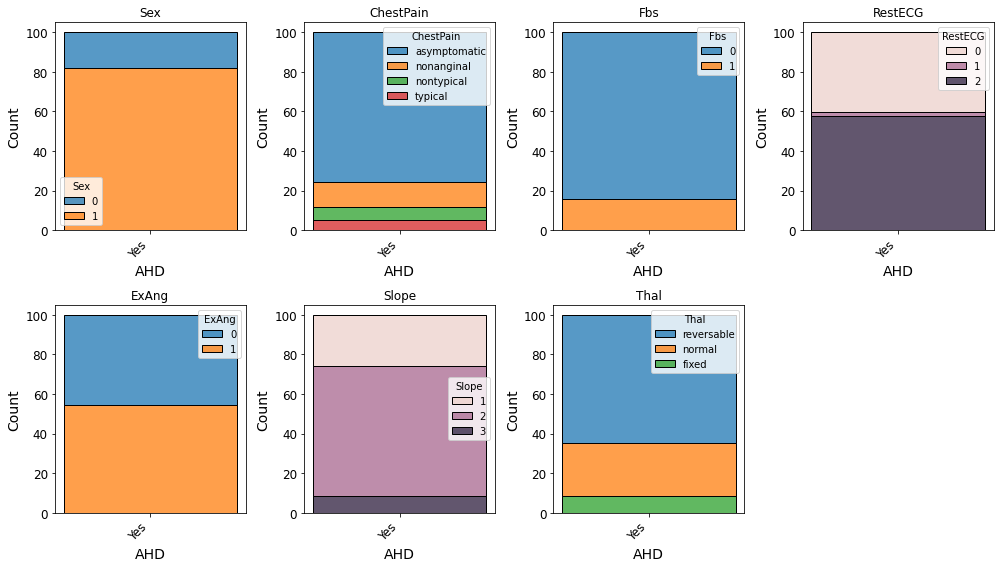

In [17]:
plt.figure(figsize=(14,8))
da.plotPositiveTargetByCats(dfheart, cats, "AHD", subplot_tpl=(2,4));

**Yorumlar**

Kalp hastalığı olanların çoğunluğu;
- Thal değeri reversable 
- Erkek 
- slope=2 
- Fbs=0
- göğüs ağrısı asemptomatik olanlar

Her bir kategorik feature ve numerik feature çifti için target'ın ortalama değerlerine bakalım.

In [18]:
# çok fazla grafik çizdiği için şimdilik geçici kapattım
# da.plotTargetForNumCatsPairs(dfheart,nums,cats,"AHD",2.4,0.9)

Son olarak da targetın diğer kategoriler bazında ortalama numerik değerlerine bakalım

In [19]:
# çok fazla grafik çizdiği için şimdilik geçici kapattım
# da.plotCategoricForNumTargetPairs(dfheart,nums,cats,"AHD",2.4,0.9)

### Korelasyonlar

Şimdi de korelasyonlara bakalım, bunun için <a href="">dython</a> kütüphanesinden faydalanacağız. Zira bu kütüphane ile hem numeric-numeric, hem numeric-kategorik, hem de kategorik-kategorik korelasyonlar tek bi fonksiyonla elde edilebilmektedir.

2022-06-02 12:48:43,118 [12420] WARNING  py.warnings:109: [JupyterRequire] c:\users\volka\appdata\local\programs\python\python38\lib\site-packages\scikitplot\plotters.py:33: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  warnings.warn("This module was deprecated in version 0.3.0 and its functions "



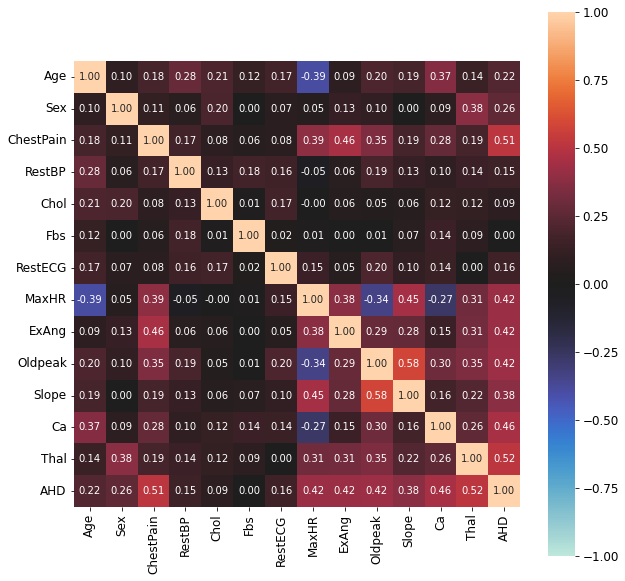

In [20]:
from dython.nominal import cramers_v, correlation_ratio, associations
corrdict=associations(dfheart,nominal_columns=cats,numerical_columns=nums,figsize=(10,10))

Targetle korele olan en yüksek N adet featureu görelim.

In [21]:
corr_results=corrdict["corr"] #dataframe
da.getHighestPairsOfCorrelation(corr_results,"AHD",5) #şimdilik N=5 aldım , modellerken bu rakamı değiştirebiliriz

Thal         0.515606
ChestPain    0.510832
Ca           0.460033
Oldpeak      0.424510
ExAng        0.421617
Name: AHD, dtype: float64

Bu korelasyon değerlerinden feature selection aşamasında yararlanabiliriz. Bu arada, üstteki grafiklerde Ca ve OldPeak'in yüksek öneme sahip olacağını söylemiştik, gerçekten de bunların korelasyonu da yüksek çıktı.

## Varsayımların kontrolü

Bazı algoritmaları modellerinizde kullanabilmek için bazı varsayımların(ön şartların) sağlandığını kontrol etmeniz gerekir. Bu notebookta ana algoritma olarak Logistic Regression'ı seçeceğiz. Onun varsayımlarına bakalım. Bu algoritmanın detaylarını <a href='Logistic%20Regression.ipynb'>şurada</a> bulabilirsiniz.

- Lineer Regresyonda olduğu gibi instanceların birbirinden bağımsız olması beklenir: Tıp dünyasından olmadığımız için bilmiyorum ama bu varsayımın karşılandığını varsayalım.
- Yine LinReg'de olduığu gibi featureler arasında collinearity olmaması gerekir: EDA'da multicollinearity gözlemlemedik.
- Outlierlara karşı duyarlıdır, dikkatlice ele alınması gerekir: Bir iki kolonda outlier vardı, bunlara bakacağız.
- Scaling'e duyarlıdır: Ölçeklerde farklılık var, scale edeceğiz.
- Instance sayısı feature sayısının en az bi 10-15 katı olmalıdır: 303 / 13 = 23 kat, ok.

## Dengeli bir dataseti mi

Buna EDA'da baktık ve dengeli olduğunu gördük. Dengesiz bir datasetinde bu durum nasıl ele alırdık bunu görmek isterseniz <a href="../Sample%20Projects/Imbalanced%20Data.ipynb">şu linke</a> bakınız.

## X ve y ayrımı

Modellerimizde iki ayrı input veririz. Birisi bağımsız değişken olan featurelar/prediktörler, diğeri de bağımlı değişken olan labellar, yani target. Genel notasyon, tüm prediktörleri X ile, target'ı y ile göstermek şeklindedir.

In [22]:
X=dfheart.iloc[:,:-1]
y=dfheart.iloc[:,-1]
X.shape, y.shape

((303, 13), (303,))

X'ler için bi notum var, eğer tek bir feature varsa bunu yine de iki boyutlu vermek lazım, bunun için şu iki yöntemden biri uygulanabilir.

<pre>
X=dfheart.iloc[:,[0]] #0'ı [] içine almak
X=dfheart.iloc[:,0].values.reshape(-1,1)
</pre>

y'nin çoğu durumda tek boyutlu olması yeterlidir. Olur da iki boyutlu olması gerekirse X'te yaptığımız aynı yöntemle yapabilirsiniz.

## Train/test setleri

<a href="https://mvolkanyurtseven.medium.com/makine-%C3%B6%C4%9Frenimi-felsefesi-4-35964b040dac">Ana sürecimizde</a> belirttiğimiz gibi, bundan sonra devam etmeden elimizdeki veri setini, eğitim ve test seti olmak üzere ikiye ayırmamız gerekecek ve model evaluation adımına kadar bu **test setine asla dokunmayacağız**.

In [23]:
#geleneksel yaklaşımla başlayalım
from sklearn.model_selection import train_test_split

`train_test_split` fonksiyonu, ki aslında `ShuffleSplit` sınıfının split metoduna ait bir wrapper fonksiyondur, yani ShuffleSplit.split() ile aynı işi yapar. Bu fonksiyon, kendisine verilen istenilen sayıdaki diziyi train ve test olmak üzere belirlenen oranda ayırır. Sadece X verirseniz X_train ve X_test elde edersiniz, X ve y birlikte verirseniz y'nin de train ve test setini elde edersiniz.

In [24]:
#hızlıca bi test edelim, nasıl çalıştığını görelim
sonuc=train_test_split(X,test_size=0.2, random_state=42)
len(sonuc) # 2 çıkacak, biri train seti biri test seti

2

Buradaki **test_size**, datasetin ne kadarını test için ayıracağız, bunu gösterir. **random_state** değeri ise şu işe yarar: Bu işlem dataframein rasgele bölgelerinden seçilerek yapılır ve her çalışıtırdığımızda aynı sonucu görmek istersek, ki istemeliyiz, çünkü ara ara modelimizi tekrar tekrar çalıştıracağız, hep aynı yerden bölündüğünde emin olalım ki, sonuçlarımız uyumlu olsun ve gerekli değişiklikleri yapabilelim. Bu random_state parametresine herhangi bi değer atanabilir, 1,3,5,42, farketmez. Bir de burda görünmeyen(o yüzden default değerini alır) **shuffle** parametresi var ki, rasgele bölgelerden seçme işini buna True(default bu) diyerek yapıyoruz, False olsaydı, datanın en alttan %20'sini eğitime ayırıp ilk %80ini train yapacaktı. Biz genelde bunu True bırakacağız, bildiğim kadarıyla bir tek Time Series problemlerinde False yapılır, o problemin doğası gereği.

Evet, şimdi bu fonksiyonun yaygın kullanım şeklinde bakabiliriz.

In [25]:
X_train, X_test=train_test_split(X,test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((242, 13), (61, 13))

In [26]:
#veya daha da yaygın haliyle
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)
list(map(np.shape, (X_train, X_test, y_train, y_test)))

[(242, 13), (61, 13), (242,), (61,)]

In [27]:
# tiplerine bakalım
list(map(type, (X_train, X_test, y_train, y_test)))

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series]

X'ler çok sayıda kolondan oluştuğu için Dataframe iken, y'ler tek kolonlu olduğunda Series'dir. Eğer y'yi oluştururken bir de values deseydik o zaman numpy array olurdu, ki bazen dememiz gerekecek.

**Önemli:** Bu şekilde random bir şekilde eğitim ve test setlerimizi böldük. Birçok yerde de bu şekilde anlatılır ve geçilir ancak durum her zaman bu kadar basit değil. Mesela, bu dataseti için size danışmanlık veren bir hekim Thal değerinin sonuçlara çok etki ettiğini söylemiş olsun veya EDA ile bunu siz keşfetmiş olun. Böyle bir durumda sizin öyle bir test seti ayırmanız lazım ki, ana kitleyi temsil etsin. Bunun için `stratified sampling` denen bir yöntem var, bunu yapmalısınız. Bazen de veri setiniz imbalanced olduğunda, yani target kolonda minority class majoritynin çok küçük bir oranına denk geliyorsa, yine test seti bu target classa göre orantısal bölmeniz lazım. 

Peki ya hem aynı anda target'a hem de ExAng featureına göre orantısal bölmek isteseydik? Kaynaklara bakın, orda bi link bulacaksınız. Biz burada sadece Thal'e göre stratify bölelim.

In [28]:
#Thal'de null değerler olduğu için fillna yapıyoruz, stratification için gerekli
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, stratify=dfheart.Thal.fillna("NA"), random_state=42)

Aşağıda bir yerde yanlışlıkla dfheart'ı kullanmayalım diye onu siliyorum, pipeline yaparken tekrar oluşturacağız zaten.

In [29]:
del dfheart

### Kaynaklar

- https://en.wikipedia.org/wiki/Stratified_sampling
- https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36
- https://scikit-learn.org/stable/modules/cross_validation.html#stratification
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html 
- https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
- https://stackoverflow.com/questions/45516424/sklearn-train-test-split-on-pandas-stratify-by-multiple-columns
- https://medium.com/analytics-vidhya/three-steps-in-case-of-imbalanced-data-and-close-look-at-the-splitter-classes-8b73628a25e6

## Preprocessing / Feature engineering

### Ön bilgiler

**fit ve transform kavramları**

Daha önce, model kurmanın matematiksel bir model oluşturmak olduğunu söylemiştik. Başka bir ifadeyle, datamızı modele uydurmuş oluyoruz. Buradaki uymak ifadesi önemli, zira Python'da bu ifade, İngilizce karşılığı olan fit metodu ile karşılık buluyor.

Ama bir modeli fit etmek ile preprocessing adımında yaptığımız fit ve transform işlemleri birbirinden farklıdır.

Preprocesingdeki fit ile bir hesap yaparız, mesela imputation yapacaksak, her bir kolonun ortalama değerlerini hesaplamış oluruz ve bunlara imputer objesinin statistics_ attribute'i ile ulaşabiliriz. Bir de üzerine transform yapınca, veri setindeki tüm null alanlar bu ortalama değerlerle replace edilir. sklearn kütüphanesinde iki işlemi ardışık yapan bir de **fit_transform** metodu bulunur.

Genel kullanım şöyledir:
<pre>
X_train=preprocesser_opjesi.fit_transform(X_train) -->train setinde fit_transform
X_test=model.transform(X_test) -->test setinde sadece transform. Yani diyoruzki X_train'den öğren ve uygula ama sonra X_test için yeniden öğrenme, trainde öğrendiğin değerleri kullan, veri sızıntısı yapma.
</pre>

Bir model fit ettiğimizde bunu bir değişkene atamaya gerek yoktur, zaten dönen şey modelin kendisidir. Modelin eğitilmesiyle birlikte eğitim sonrası oluşan attributeler("\_" ile bitenler) kullanılabilir hale gelir.

Supervised modeller sadece fit edilirken, unsupervised modeller(clustering v.s'ye ek olarak scaling gibi tüm feature processing işlemleri dahil) ayrıca transform da edilir. Transform ile elimizdeki verinin artık fit edilmiş modele göre yeni bir temsilini elde ederiz. Fit'ten farklı olarak transform ettiğimizde yeni sonuçları bir değişkene atamak gerekir, ki bu yeni değişken artık transform edilmiş halini tutabilsin.

**Input Formatı**

<a href="https://mvolkanyurtseven.medium.com/makine-%C3%B6%C4%9Frenimi-felsefesi-5-78cd290b46f2">EDA ve Preprocessing postumda</a>, Makine öğrenme algoritmaları hemen herşeyi sayı olarak içeri alır, buna göre model oluşturur demiştik. Ancak bu tek şart değildir. Bu sayıların formatı da önemlidir. İşte, algoritmadan algoritmaya değişmekle birlikte çoğu zaman input listesinin 2 boyutlu bir matris olması gerekir. 2'den fazla değişkenin olduğu durumda bu zaten mecburen böyledir, ancak tek boyutlu input olan ve özellikle öğretim amaçlı hazırlanmış veri setlerinde bazen tek bir değişken kullanılır. Bu tek değişkenin de 2 boyutlu hale getirilmesi gerekir. Bunun için de dataframein ilgili kolonunun values özelliği ile değerleri alınırken **reshape(-1,1)** ile 2 boyutlu hale getirilmesi gerekir. 

Bunun dışında yine algoritmadan algoritmaya değişmekle birlikte, inputlar bazen numpy dizisi(dataframede bir kolonun values özelliği ile elde edilir), bazen de dataframe olarak modele sokulabilir.

### İşlem sırası

Burdaki işlemlerin net bir sırası olmamakla birlikte, farklı kaynaklardan derlediğim ve kendi tecrübemle harmanladığımda şu sıralama uygun gibi görünmekte. Duruma göre küçük ayarlamalar yapılabilir. Hatta vakit varsa, bazı işlemlerin sırasını değiştirerek denemek ve sonucu görmek de faydalı olabilir. Ne de olsa Machine Learning ampirik bir alan, birçok şey deneme yanılma ile yapılıyor(GridSearch konusunda bunu daha iyi anlayacaksınız)

Biz bu kısımda, bunları önce tek tek yapmayı öğreneceğiz, sonra pipeline kullanarak tek seferde nasıl yapıldığını göreceğiz.

Benim düşündüğüm sıra şu şekilde:

- data cleaning(Kirli data hep gelecekse, bu da pipeline içine konur, aksi halde tek seferde bitirilir)
- imputation(missing value handling) veya deletion: outlier treatten önce olmalı, IQR’ları etkiliyor
- outlier handling (Scalingden önce olmalı)
- gerekiyorsa discretization(onehot öncesinde yapılmalı, ki bunlar da encode olabilsin)
- feature creation/extraction
- feature selection/dimension reduction
- encoding(categoricler için sırası çok kritik değil, ordinallerse scalingden önce olabilir)
- distribution transform for skewed data(scaling öncesinde yapmak lazım ki normal dağılıma uygun hale gelsin)
- scaling 
- ovesampling/undersampling for imbalanced data (bu notebookta yapmayacağız)

ÖNEMLİ NOT: Bu işlemler Pipeline denen yapılarla disiplin altına alınır ve hem train hem test için uygulanabilir olması nedeniyle çok verimlidirler. Ancak bu notebook, eğitim amaçlı olduğu için öncelikle herşeyi ayrı ayrı göreceğiz, Pipelineları daha sonra göreceğiz. Bu arada burdaki süreç kesin bir süreç olmayıp duruma göre küçük yer değiştirmeler yapılabilir. Ör:Feature selection olarak Embedded-Lasso seçilirse, bunu öncesinde scaling yapmak gerekebilir.

<a href="https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b">Şurada</a> da güzel bi özet var, oraya da bakmanızda fayda var.

Bu aşamadaki işlerin büyük kısmını geleneksel kütüphanelerle(pandas, numpy, sklearn, scipy) ile yapmaya çalışacağız. Bununla birlikte iki ayrı kütüphane daha keşfettim, eminim dahası da vardır. Bunlara da bakılabilir.

- https://feature-engine.readthedocs.io/en/1.2.x/index.html veya https://github.com/feature-engine/feature_engine
- http://rasbt.github.io/mlxtend/ veya https://github.com/rasbt/mlxtend

Önce train/test sonra feature engineering yapma sebebimizi merak ediyorsanız, şu linklere bakabilirsiniz.

- https://machinelearningmastery.com/data-preparation-without-data-leakage/
- https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
- https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
- https://towardsdatascience.com/6-amateur-mistakes-ive-made-working-with-train-test-splits-916fabb421bb
- https://stats.stackexchange.com/questions/267012/difference-between-preprocessing-train-and-test-set-before-and-after-splitting
- https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data


### Data Cleaning

Aşağıdakine benzer temizlik işlemleri yapılabilir.

- Mükerrer kayıtları silme
- Hatalı kayıtları silme
- veri kalitesi problemlerini düzeltme(veri yönetişimi/data governance çalışmaları önemli): 
    - "Direkt Bnk", "Direkt Bank", "DIREKT Bank."
    - A kolonu B'den büyük olmaması gerektiği halde durum buysa
    - A kolonunda bulunmaması gereken değerler varsa (Ör:il kodlarında 89, sıcaklık değeri olarak 500)    
- Dönüşüm işlemleri. Ör: 100 TL--> 100
- Veri tipi dönüştürme

Bizim datamızda var mı diye bakalım.

In [30]:
#datanın sınırlarını görelim, anormal bişey var mı
X_train.describe()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,240.000000
mean,54.909091,0.661157,132.235537,249.611570,0.157025,1.037190,149.867769,0.318182,0.971074,1.557851,0.700000
std,9.064545,0.474297,17.554370,53.755304,0.364578,0.995144,23.120447,0.466736,1.115075,0.589289,0.964647
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,136.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,130.000000,243.500000,0.000000,2.000000,152.500000,0.000000,0.600000,2.000000,0.000000
75%,61.000000,1.000000,140.000000,277.750000,0.000000,2.000000,167.750000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [31]:
#categoriklerde de uniqe değerlere bir daha bakalım
da.getColumnsInLowCardinality(X_train)

Unique items in column Sex
[0 1]

Unique items in column ChestPain
['nonanginal' 'nontypical' 'asymptomatic' 'typical']

Unique items in column Fbs
[0 1]

Unique items in column RestECG
[0 2 1]

Unique items in column ExAng
[0 1]

Unique items in column Slope
[1 2 3]

Unique items in column Ca
[ 1.  2.  0.  3. nan]

Unique items in column Thal
['normal' 'reversable' 'fixed' nan]

You may want to consider the numerics with low cardinality as categorical in the analysis


['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Ca', 'Thal']

Numerik sınırlar ve kategorik değerler makul görünüyor. Bi işlem yapmaya gerek yok.

### Imputation

Verisetindeki null alanların nasıl ele alınacağı aşamasıdır. 

- En başta yaptığımız korelasyon analizine bakıp bir featureun önem derecesine göre ne yapacağımıza karar verebiliriz. Mesela target'a çok az etkisi olan bi kolonsa ve sayı fazla ise o kolon silinebilir.
- Numerik ve kategorik kolonlar ayrı ele alınmalıdır.
- outlierları etkilediği için önce bunları yapmak lazım
- median yerine mean kullanılacaksa ve ortalamayı etkileyen büyük outlierlar varsa önce onlar halledilmelidir.
- NaN, \<NA>, nan, None ayrımına dikkat. Bunlarla ilgili <a href="..\Inplace and Nulls Operations.ipynb">şu linke</a> bakmanızda fayda var.
- Bazen boş değerler null anlamına değil özel bir anlama sahip olabilir. Ör: Bankacılıkta kredili müşterinin en son ne zaman takibe girdiği bilgisi null ise bu hiç takibe girmediği anlamına gelebilir. Bunu veri sahibine sorup öğrenmek gerekecektir. Duruma göre bunlar için feature extraction aşamasında bir kolon açılıp bu bilgi yazılabilir. Ör:DahaÖnceTakip Flag gibi bir feature.(Bu işlem, SimpleImputer'ın **add_indicator** parametresi ile de sağlanabilir)

**categorikler için alternatifler**

- en sık yapılan ama en basit ve yetersiz olan yöntem mod ile impute etmek olabilir
- bir alternatif en önemli kolona göre veya targeta göre mod aldırabiliriz, özellikle mod açık ara öndeyse
- bir alternatif de classification uygulamak olabilir, yani bi classification algoritması ile bunları tahmin etmeye çalışabiliriz(Model içinde model)
- bir alternatif de onehot encoding yapıp sonra iterative imputation yapmak olabilir ama bunun da kendi içinde olumsuzlukları var
- Eldeki datada null olmayan satırları alabilir, bunlardan ilgili kolonlarda random null yaratıp bunları test etmeye çalışabiliriz, sonra gerçek değerlerle karşılaştırıp en az hatalı imputation yöntemini seçebiliriz.
- Missing diye bi kategori yaratabiliriz.

**numerikler için alternatifler**
- En yaygın ama bence yine yetersiz olan alternatif mean veya daha iyisi medianla replace etmek, zira median outlilerlara duyarlıdır.(Biz bu notebookta işlem basitliği olması adına bu yöntemi tercih edeceğiz, diğer yöntemleri kullandığım notebooklara da link vereceğim)
- ilgili kolonun full mean/medianını almak yerine belli kategoriler bazında mean/median alınabilir
- Bir başka alternatif regression uygulamak olabilir(manuel veya IterativeImputer kullanarak)
- KNNImputer uygulanabilir
- Hatta korelasyon bile kullanılabilmektedir(kaynaklara bakın)

Bu yukarıdakilerin hepsi replace yöntemidir. Alternatif olarak "en az %xi boş olan kolon veya satırları sil" yaklaşımı da benimsenebilir.

veya bunların hepsi gridsearch içinde denenebilir.

Bunların birçoğunu <a href='../Sample%20Projects/Imputation%20Ornekleri.ipynb'>şu notebookta</a> denedim.

Biz burada çoğunlukla **impute modülündeki SimpleImputer sınıfı** üzerinde ilerleyeceğiz. Imputation'ı sadece null olan kolonlarda uygulamak yeterlidir. Ancak eğer şuan datada null yoksa fakat ilerde gelme ihtimali olduğunu düşündüğünüz kolonlar varsa onlara da, hatta tüm X'lere uygulanabilir.

numerikler ve categorikler için iki ayrı işlem yapılacağı için iki ayrı imputer objesi yaratıyoruz.

In [32]:
from sklearn.impute import SimpleImputer
numimp = SimpleImputer(strategy="median")
catimp = SimpleImputer(strategy="most_frequent")

In [33]:
#datasetimiz küçük olduğu için tüm kolonlarda imputation yapabiliriz
numimp.fit(X_train[nums]) #daha önce belirttiğimiz üzere burada fit ederek median hesaplanmış oluyor
#şimdi bu medianları görelim
numimp.statistics_

array([ 56. , 130. , 243.5, 152.5,   0.6,   0. ])

In [34]:
#şimdi de bu değerleri verisetindeki missinglere yerleştirelim
X_train_num_imp = numimp.transform(X_train[nums]) #bu noktada artık Dataframe değil numpy array olur. 
#fit ve transformu bir arada yapan fit_transform metodu da mevcuttur ve genelde bu kullanılır
X_train_num_imp[0]

array([ 67., 152., 277., 172.,   0.,   1.])

In [35]:
#sonuçları dataframe üzerine tekrar yazabiliriz
X_train[nums] = X_train_num_imp
X_train[nums].isnull().any().sum() #kontrol edelim

0

In [36]:
#cats için olanı fit_transform ile tek seferde yapalım
X_train_cat_imp = catimp.fit_transform(X_train[cats])
catimp.statistics_
X_train_cat_imp[0]

array([0, 'nonanginal', 0, 0, 0, 1, 'normal'], dtype=object)

In [37]:
X_train[cats] = X_train_cat_imp
X_train[cats].isnull().any().sum() #kontrol edelim

0

**İlave Kaynaklar**

- https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer
- https://www.numpyninja.com/post/mice-and-knn-missing-value-imputations-through-python
- https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICE.html
- https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook
- https://arxiv.org/ftp/arxiv/papers/2107/2107.00100.pdf
- https://dergipark.org.tr/en/download/article-file/1394639
- http://dept.stat.lsa.umich.edu/~kshedden/Python-Workshop/correlation_missing_data.html

### Outlier handling

Tespit kısmını EDA’da görmüştük. Şimdi bunlarla ne yapacağımıza bakalım. 

- Mean/Median Imputation: Eğer outlierların hatalı olduğunu düşünüyorsak bunlara missing/null valuelar gibi davranabiliriz.
- Trimming/Deletion: Bunların sayısı toplam instance sayısına oranla çok düşükse bunları silebiliriz.
- Top, Bottom Coding(Cap uygulama): Bir çeşit imputation, fakat Q1-1,5IQR ve Q3+1,5*IQR gibi değerlere(veya tespit edeceğiniz başka bir değere) sabitlenir.
- Discretization:Veri setini baremlere(bin'lere) ayırma
- Robust Scaling:MinMax veya StandartSacaler yerine RobustScaler kullanılabilir.
- Data transformation: Log transformation veya Box-Cox transformation. Ancak bu daha çok skewness çözümüdür, outlier çözümü değil. Çoğu yerde bu da seçenekler içinde diye ben de koydum, ama bunu kullanmayın derim.

NOT: Sadece mevcut datada değil, yeni datada da outlier var mı kontrolü de önemlidir, ki pipeline içindeki outlier handler'ımız bunu yapıyor olacak.

Önce bi histogram ile bakalım

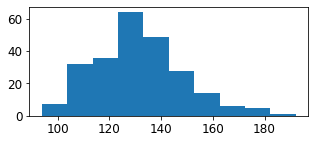

In [38]:
plt.figure(figsize=(5,2))
plt.hist(X_train.RestBP);

Çok büyük bir skewness yok, ama yine de log alıp ne olacağını görelim.

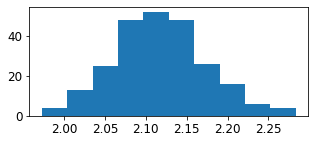

In [39]:
plt.figure(figsize=(5,2))
plt.hist(np.log10(X_train.RestBP));

log alınca outlierlar gitmiş gibi görünüyor, ama emin olmak içn bir de boxplot ile bakalım

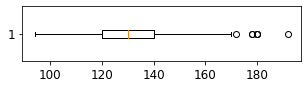

In [40]:
#logsuz
plt.figure(figsize=(5,1))
plt.boxplot(X_train.RestBP,vert=False);

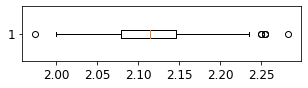

In [41]:
#loglu
plt.figure(figsize=(5,1))
plt.boxplot(np.log10(X_train.RestBP),vert=False);

hala bi miktar outlier görünüyor. Veri sayımız çok olmadığı için silme alternatifini düşünmeyeceğim. O zaman cap koymayı deneyelim.

In [42]:
Q1 = X_train["RestBP"].quantile(0.25)
Q3 = X_train["RestBP"].quantile(0.75)
IQR = Q3-Q1
topRestBP=(Q3 + 1.5 * IQR)
bottomRestBP=(Q1 - 1.5 * IQR)
X_train["RestBP"]=np.where(X_train["RestBP"]>topRestBP,topRestBP,X_train["RestBP"])
X_train["RestBP"]=np.where(X_train["RestBP"]<bottomRestBP,bottomRestBP,X_train["RestBP"])

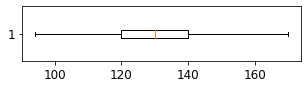

In [43]:
plt.figure(figsize=(5,1))
plt.boxplot(X_train.RestBP,vert=False);

Böylece hiç log almaya gerek olmadı. Bu arada bence outlierların derecesi o kadar da büyük değildi, burda robust scaling yapmak yeterli olabilir. Imputationda söylediğimiz gibi burda da alternatifleri gridsearchte denemek gerekebilir.

Şimdi bir de Chol için bakalım.

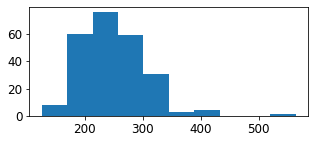

In [44]:
plt.figure(figsize=(5,2))
plt.hist(X_train.Chol);

Çok büyük bir skewness yok, ama yine de log alıp olacağını görelim.

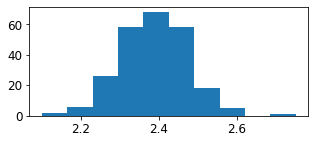

In [45]:
plt.figure(figsize=(5,2))
plt.hist(np.log10(X_train.Chol));

log alınca bile hala outlierlar var gibi, zira yukarıda belirttiğim gibi log transformasyon daha çok skewnessı azlatmak için kullanılır, outiler handling için değil, bir de boxplot ile bakalım

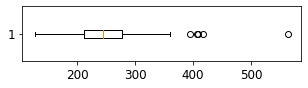

In [46]:
#logsuz
plt.figure(figsize=(5,1))
plt.boxplot(X_train.Chol,vert=False);

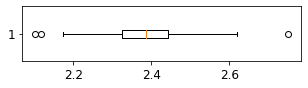

In [47]:
#loglu
plt.figure(figsize=(5,1))
plt.boxplot(np.log10(X_train.Chol),vert=False);

hala bi miktar outlier görünüyor. Yine cap koyalım.

In [48]:
Q1 = X_train["Chol"].quantile(0.25)
Q3 = X_train["Chol"].quantile(0.75)
IQR = Q3-Q1
topChol=(Q3 + 1.5 * IQR)
bottomChol=(Q1 - 1.5 * IQR)
X_train["Chol"]=np.where(X_train["Chol"]>topChol,topChol,X_train["Chol"])
X_train["Chol"]=np.where(X_train["Chol"]<bottomChol,bottomChol,X_train["Chol"])

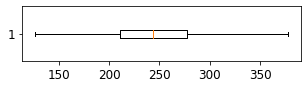

In [49]:
plt.figure(figsize=(5,1))
plt.boxplot(X_train.Chol,vert=False);

Bu cap koyma işlemini nihai pipeline içinde custom bir function veya class olarak yerleştireceğiz.

**İlave kaynaklar**

- https://scikit-learn.org/stable/modules/outlier_detection.html
- https://stackoverflow.com/questions/52346725/can-i-add-outlier-detection-and-removal-to-scikit-learn-pipeline
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/plot_outlier_rejections.html

### Discretization

Numerik kolonların kategorik kolonlara çevrilme işlemidir. Bu işlem çok küçük farkları olan numerik değerlerin target üzerinde önemli bi fark yaratmadığı durumda yapılır. Mesela 25 yaşında olmakla 27 yaşında olmak çok bi fark yaratmıyorsa bunları 25-30 gibi bir yaş grubunda biraraya getirebiliriz.

Genel olarak yapılma sebebini şöyle sıralayabiliriz:

- Çalıştığımız problemde ağırlıkla kategorik değerler vardır, kalan 1-2 değer de target üzerinden çok fark yaratmıyorsa, ve algoritmamız sadece kategorik veri isteyen bir algoritmaysa
- kategorik targetle ilişkisini daha iyi yorumlayabilmek için
- Signal-to-Noise Ratio oranını düşürmek, yani rakamlardaki küçük dalgalanmaların model sonucunu etkilemesine izin vermemek için
- Outlier handling amacıyla

**Türleri**

*Unsupervised*
- Equal-Width:Her birinin genişliği sabit olan N adet grubua ayırma. width=(max-min)/N
- Equal-Frequency:Yine N grup, ama bu sefer hepsindeki genişlik farklı olabilir, ama gruplar içindeki elema sayısı aynı.
- K-Means

*Supervised*
- Decision Trees

Şimdi mesela çok fazla değeri olan Chol değerine bakalım. Normalde bunda outlier handling yaptık ama alternatif olarak discretizastion da yapabilirdik. Nasıl yapıldığına bakalım ama bunu kullanmayacağız.(Gridsearchte hem kullan hem kullanma şeklinde bir seçenek de yapabiliriz)

In [50]:
# Equal-Width
# pd.cut ile de yapılabilirdi ama Pipeline için sklearn kullanmak daha iyi, tıpkı imputationda pd.fillna yerine SimpleImputer kullanmak gibi
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretizer.fit_transform(X_train.Chol.values.reshape(-1,1))[:5]

array([[5.],
       [2.],
       [6.],
       [4.],
       [8.]])

In [51]:
# Equal frequency
# pd.qcut ile yapılabilirdi
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
discretizer.fit_transform(X_train.Chol.values.reshape(-1,1))[:5]

array([[7.],
       [1.],
       [7.],
       [5.],
       [9.]])

In [52]:
#Kmeans
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
# discretizer.fit_transform(X_train.Chol.values.reshape(-1,1))[:5] #---->hata aldım, numpy versiyonuyla alakalı sanırım,bilahare düzelteceğim

Kmeans ile ilgili örnek için aşağıdaki ilk kaynağa bakınız.

**ilave kaynaklar**

- https://towardsdatascience.com/an-introduction-to-discretization-in-data-science-55ef8c9775a2
- https://www.statisticshowto.com/discretization/
- https://www.javatpoint.com/discretization-in-data-mining
- https://datascience.stackexchange.com/questions/19782/what-is-the-rationale-for-discretization-of-continuous-features-and-when-should

### Feature extraction/Feature creation

Mevcuttaki featurelardan yeni featurelar üretilebiliyor mu, bunlara bakılabilir. Bu, mevcut featureların birbiriyle çarpımı veya toplamı olabileceği gibi bir veriden daha anlamlı/faydalı olabilecek başka bir bilginin çekilip çıkarılması da olabilir. Yeni bir feature üretme işlemidir. Dimension reductionın tam tersi gibi görünse de aslında aynı amaca da hizmet edebilir, zira yeni ürettiğimiz alandan sonra onu üretirken kullandığımız alanları artık silebiliriz. Birden fazla kolonu kullanıp 1 alan ürettiysek, ve bu alanları sildiysek, örneğin oranlama yaptıysak, dimension reduction yapmış olduk. Örneğin hedef ve gerçekleşenleri oranlayıp hedef gerçekleşme oranı bulmak gibi. Birden fazla kolonu kullanıp 1 alan ürettiysek, ve hiç bir alanı silmediysek sayıyı artırmış oluruz, ama bunda da geçerli bir nedenimiz vardır, zira kolonlar kendi başına da anlamlıdır, oranlandığında da.

İlkine örnekler:

- Brüt + İptal = Net Satış
- Kar / Personel Adedi = Personel başına kar

İnteraction yaptık diyelim: X=A/B dedik. böyle bi durumda, A ve B’nin ikisini de tutmaya gerek yok, birini tutalım diğerini atabiliriz, <a href='https://www.statology.org/dummy-variable-trap/'>dummy variable tuzağı</a> olmasın. Ama hangisini? Ör: risk/limit. Duruma göre değişir. Amacımıza göre. Domain bilgisi önemli.

Peki A/B mi A/C mi yapacağımızı nerden bileceğiz? Biraz akıllı tahminler yapıp, denemeler yapabiliriz. Hepsini denemek çok maliyetli olabilir. Bu arada, Deep Learning'te böyle birşey yapmaya gerek olmuyor, bu aşama sadece pure Machine Learning modelleri için geçerlidir.

İkincisine örnekler:

- Tarihten ay/yıl/gün bilgilerinin çıkarılması
- Unvan ve ismin birlikte yazıldığı bir kolondan unvanın çıkarılması
- Titanic verisetinde yapıldığı iddia edilen, kamara numarasından odanın geminin neresinde bulunduğu bilgisi(sağ üst kıç tarafındakiler en geç battığı için kurtulma şansları daha fazla olmuş)
- Numerik değerlerin discretize edilmesi: Yaş bilgisinin 5 ayrı grupta gösterilmesi

Bizim veri seti özelinde konuya çok hakim olmadığım için bi işlem yapmayacağız.

**ilave kaynaklar**

- https://towardsdatascience.com/the-hitchhikers-guide-to-feature-extraction-b4c157e96631
- https://scikit-learn.org/stable/modules/feature_extraction.html

### Feature Selection/Feature elimination

Gerçek hayat problemleriyle uğraşırken elimizde birçok veri olacaktır ve hangisinin model sonucuna katkısı olacağından emin olmak gerekiyor. Dimension redcution'a benzemekle birlikte, feature selectionda(FS), varolan featurelar az sayıdaki isimsiz featurelara sıkıştırılmak yerine direkt olarak elenirler/tutulurlar. Bunun için de targeta en yüksek etkisi olanlar tespit edilip, kalanlar çıkartılmaya çalışılır. Gerekirse arkasından yine de dimension reduction yapılabilir.

Burda önemli bir konu, bu işlemi encoding işleminden önce mi sonra mı yapılacağı. Bu konuda net bir görüş görmemekle birlikte bu konuyu ele alan bi makale de bulamadım, sadece bu soruyu soranlar var, verilen cevaplarda ise iki seçenek de savunuluyor. Bu durumda en iyisi, deneyip görmek olacak gibi.

Faydası nedir, ne zamana yapılmalıdır?:

- Elimizde çok sayıda feature olduğunda, overfittingle karşı karşıyayızdır, bu riski azaltmak için(overfitting kavramını daha sonra göreceğiz)
- Gereksiz yanıltıcı datadan arınmak daha yüksek isabetli tahmin yapmamıza da sağlar, accuracy yükselir.
- Eğitim süresi kısalır.

FS'nın model başarı performansına fayda sağlayacağının bi garantisi yoktur, denenip görülmelidir. Bazen arkasından yine de PCA yapmak gerekebilir. Bunun da etkisinin ne olacağını denemeden bilemeyiz.

FS ve Feature Extraction arasındaki farklar için <a href="https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when">şurada</a> güzel bir açıklama var.

Elimizdeki probleme(classification/regression), input ve outputun tipine göre kullanılacak yöntemler değişebilecektir. Üç ana yaklaşım vardır:

- **1)Filter metodları:** Targetla yüksek seviyede korele olan featurelar seçilir, eğitim yapılmadığı için **hızlıdır ama isabet oranları diğer yöntemlere göre düşüktür**. Gözle(scatter/heatmap) veya aşağıdaki testlerle yapılabilir.
    - Pearson’s/Spearman's correlation: Multicollinearity varsa(r>0.9), yani iki değer arasında korelasyon çok yüksekse, birini kullanmasak da olur. ör:metrekare ve odasayısı. Ama bunlardan hangisi daha çok etkiliyor gibi bir çıkarım da yapacaksak ikisini de almamız lazım. Feature selection yapmayıp, PCA yaparsak da korele kolonları yüksek oranda tek kolonda birleştirir. Ama PCA yorumlamayı zorlaştırıyor, mümkünse bu aşamada bitirmek lazım. Bu arada mulitcollinear olmayıp yine de hatırı sayılır bir korelasyon varsa bu aşamada çıkartamayız ama arkadan bi PCA yapmak işe yarayabilir. PCA yapacaksanız çıkarmaya gerek yok. PCA yapmıyorsan 0.9 üstünü çıkarmak performansı iyileştirir ama sonucu ille de çok iyileştirir diyemeyiz. 
    - Chi-square test
    - Cramer's V coefficients    
    - wald's test
    - regressionda statsmodeldeki p-value'su yüksek olanlar
    - Düşük variancelılar.(Uç örnek: Var=0 ise hepsi aynıdır. VarianceThreshold bunu yapacak)
    - Full cardinalitesi olanlar: Müşteri numarası gibi, tüm kolonun benzersiz değerler içerdiği kolonlar
    
- **2)Wrapper metodlar:** filter metodlara göre daha iyi sonuçlar vaat eder ama eğitim gerektirdiği için daha uzun sürer. Arka planda greedy heuristic(sezgisel) algoritmalar kullanır. Featurelar arasındaki interactionı tespit edebilirler.
    - Forward Selcetion
    - Backward Elimination
    - Recursive Feature Elimination (RFE)
    - Genetic algoritmalar
    
- **3)Intrinsic/Embedded metdolar**: Kendi içinde feature selection metodları olan modellerdir. Hızlı ve verimlidir. Sonuçları filter metodlara göre daha iyidir. coef_ veya feature_importance_ gibi attriubteleri olan modeller kullanılır.
    - Lasso regularization: <a href="Linear Regression.ipynb">Regressyon notebook'unda</a> görmüştük, multicollinear olanlara 0 katsayı veriyordu. Ama multicollinearity yoksa çok da işe yarayacağını düşünmüyorum.
    - Ağaç bazlı algoritmalar(DT, RF, XGBoos v.s):DT ve RF gibi algoritmalarda embedded bir şekilde feature importance elde ediliyor, diğerlerinde yukarıdaki metodlarla aslında dolaylı olarak önemli featureları elde edebiliyoruz.

Bunlardan önce yapılacak bazı manuel kontroller de var aslında.

- İş bilgisi kullanarak gereksiz kolonlar silinebilir
- Çok null olanlar silinebilir,(kolonun en az yarısı nullsa)
- A+B=C diye türetim yaptıysak A ve B silinebilir

#### Filter metod: VarianceThreshold(numerikler için)

Düşük varyanslı kolonları elimine eder. Bi threshold veririz, onun altında varyansı olanları eler. Sağlıklı çalışabilmesi için tüm kolonlar aynı ölçekte olması(normalize edilmesi) lazım, yoksa hepsinde aynı varyansı beklemek anlamsız. O yüzden bu kısmın scalingden sonra gelmesi gerektiği aşikar. Scaling olarak da kesinlikle StandartScaler kullanıl**ma**malı, çünkü bu zaten tüm featureların varyansını 1 yapar.

Univariate bir yöntem olduğu yani targetla ilişkiye bakmadığı için önemsiz bir kolonu seçme ihtimali de var. Ben bunu kullanmayı çok önermem.

In [53]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
X_scl=MinMaxScaler().fit_transform(X_train[nums])
np.var(X_scl,axis=0)

array([0.03551495, 0.04867842, 0.03780438, 0.0310207 , 0.03221265,
       0.10255826])

In [54]:
sel = VarianceThreshold(threshold=0.035)
X_train_VT = sel.fit_transform(X_scl)
X_train[X_train[nums].columns[sel.get_support(indices=True)]].head() 

,Age,RestBP,Chol,Ca
227,67.0,152.0,277.0,1.0
185,63.0,140.0,195.0,2.0
168,35.0,126.0,282.0,0.0
135,55.0,135.0,250.0,0.0
113,43.0,132.0,341.0,0.0


Sadece bu 4 kolon önemliymiş!!! Burda tabi threshold olarak neyi vereceğimizi deneme yanılma ile bulmak gerekebilir, ama dediğim gibi ben bu yöntemi sırf göstermiş olmak için gösterdim, supervised modellerde kullanmaya değmez. Bununla beraber `unsupervised` learning modellerinde kullanılabilir.

#### Filter metod: korelasyon bakma

Buna zaten EDA'da bakmıştık. Belli threshold üstündekileri seçebiliriz.

In [55]:
da.getHighestPairsOfCorrelation(corr_results,"AHD",5)

Thal         0.515606
ChestPain    0.510832
Ca           0.460033
Oldpeak      0.424510
ExAng        0.421617
Name: AHD, dtype: float64

Burda bence %30 üzeri olanlar seçilebilir.

In [56]:
da.getHighestPairsOfCorrelation(corr_results,"AHD",0.3)

Thal         0.515606
ChestPain    0.510832
Ca           0.460033
Oldpeak      0.424510
ExAng        0.421617
MaxHR        0.417167
Slope        0.380738
Name: AHD, dtype: float64

Yalnız şuna dikkat etmek lazım; kullandığımız yöntem dython kütüphanesindeki bir metoddu, bu metodun numerik-numerik ve numerik-kategorik korelasyonları benzer ölçekte olup sonuçları birbiriyle kıyaslayabiliriz ancak kategorik-kategorik korelasyonda güçlü ilişki için sonucun 1e yakın olması gerekmiyor, bunun için cramer's v metriği kullanılıyor olup yorumlaması şu tabloya göre yapılır:

<pre>
df  Small  Medium  Large
1	0.10	0.30	0.50
2	0.07	0.21	0.35
3	0.06	0.17	0.29
4	0.05	0.15	0.25
5	0.04	0.13	0.22

df=min(# of rows-1 , # of columns-1)
</pre>

Şimdi bu kategoriklere bir daha bakalım

In [57]:
corr_results[cats].loc["AHD"].sort_values(ascending=False)

Thal         0.515606
ChestPain    0.510832
ExAng        0.421617
Slope        0.380738
Sex          0.263945
RestECG      0.163215
Fbs          0.000000
Name: AHD, dtype: float64

Bizim örneğimizde df=1 olup medium etki var diyebilmek için en az %30luk değerlere bakabiliriz. Aslında yukarda seçtiğimiz %30 da zaten bunları kapsıyordu.

#### Filter metod:F-statistic

Sonra eklenecek...

#### Filter metod: SelectKBest

Aşağıda geçen metodlara göre en yüksek skora sahip olan featurelar seçilir.

*target categorikse(classification problemi):*

- input categoricse
    - <a href="https://gnarlyware.com/blog/mutual-information-exaxmple-with-categorical-variables/">mutual_info_classif</a>
    - chi2
- input numerikse
    - mutual_info_classif
    - f_classif(ANOVA)
- input mixed ise
    - mutual_info_classif
    - SelecktKBest yerine RFE veya embedded da olabilir 


*target numericse(regresyon problemi):*

- input categoricse
    - mutual_info_regression
    - f_regresion(ANOVA)
- input numerikse
    - mutual_info_regression
    - f_regresion veya direkt korelasyonların incelenmesi yapılabilir
- input mixed ise
    - mutual_info_regression
    - SelecktKBest yerine RFE veya embedded da olabilir 

In [58]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression

Öncelikle categorik verileri numerikleştirelim, bunun için OrdinalEncoder kullanabiliriz.(Encoding kısmında detaylarını göreceğiz). Ancak orjinal X_traini bozmak istemediğim için onun şuana kadarki işlemlerin yapıldığı halini içeren bir kopyasını yaratacağım ve onu orjinal olarak saklayacağım. İlerde buna tekrar ihtiyaç duyacağız.

In [59]:
X_train_orj=X_train.copy()

In [60]:
from sklearn.preprocessing import OrdinalEncoder
oe1=OrdinalEncoder(categories=[['typical', 'asymptomatic', 'nonanginal', 'nontypical']]) #ChestPain için, bu sırayla yapılsın
#RestECG zaten numerik
oe2=OrdinalEncoder() # nominaller için

X_oe1 = oe1.fit_transform(X_train["ChestPain"].values.reshape(-1,1))
X_oe2 = oe2.fit_transform(X_train[noms].values)

In [61]:
X_train["ChestPain"]=X_oe1
X_train[noms]=X_oe2

In [62]:
X_train.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
227,67.0,0.0,2.0,152.0,277.0,0.0,0,172.0,0.0,0.0,0.0,1.0,1.0
185,63.0,0.0,3.0,140.0,195.0,0.0,0,179.0,0.0,0.0,0.0,2.0,1.0
168,35.0,1.0,1.0,126.0,282.0,0.0,2,156.0,1.0,0.0,0.0,0.0,2.0
135,55.0,0.0,3.0,135.0,250.0,0.0,2,161.0,0.0,1.4,1.0,0.0,1.0
113,43.0,0.0,1.0,132.0,341.0,1.0,2,136.0,1.0,3.0,1.0,0.0,2.0


In [63]:
#outputumuz categoric ve inputlarımız mixed, o yüzden mutual information kullanalım
fs = SelectKBest(score_func=mutual_info_classif,k=5)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train) #en yüksek etkisi olan 5 kolon
X_train_fs[0]

array([2.0, 172.0, 0.0, 1.0, 1.0], dtype=object)

In [64]:
X_train.columns[fs.get_support()]
#indeklsere de ihtiyaç olursa
[e for e,x in enumerate(fs.get_support()) if x==True]

[2, 7, 10, 11, 12]

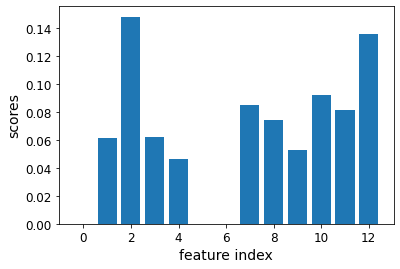

In [65]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel("feature index")
plt.ylabel("scores")
plt.show();

- Çalışan işin rassal doğasından dolayı her çalıştırdığınıda farklı sonuç çıkacaktır, bikaç kez çalıştırıp ortalama almak gerekebilir, bu da train time'ı uzatır tabiki, zaman sorunu yoksa yapılabilir.
- Bir diğer alternatif de kategorikler için chi2, numerikler için f_flassif(ANOVA) yapıp sonuçları birleştirmek olabilir.
- Ve tabiki k'nın optimal değeri için grid search yapılmalıdır.

#### Wrapper metod:Backward elimintation

Sonra eklenecek...

####  Wrapper metod:Forward elimination

Sonra eklenecek...

#### Wrapper-Exhasustive(Brute-Force)

Sonra eklenecek...

#### Wrapper-Greedy Elimination

Sonra eklenecek...

#### Wrapper metod:RFE

Bu yöntem, aslında embededed modelle wrapperların bir hibritidir. Burda önce tüm featurelarla model çalıştırılır, accuracy bi kenarda tutulur, sonra feature importancea göre en az önemli olan silinir, tekrar model çalıştırılır ve önceki accuracy ile karşılaştırılır. Çıkan sonuca göre aksiyon alınır, ta ki istenen sayıdaki feature sayısına inene kadar.

Önemli: Bu aşamada, model çalışacağı için modele girecek verilerin düzgün şekilde encode edilmesi gerekir. Yukarıda geçici olarak ordinalencoding yapmıştık, zira chi2/anova testleri için verilerin numerik olması gerekiyordu. Akabinde nihai bir model çalışmadığı için o şekilde kalmasında sorun yoktu, ancak şimdi model çalışacağı için ordinaller dışındaki categorik verilerin yani "noms" değişkenindeki nominal featureların onehot encode edilmesi gerekiyor. Mevcut haliyle modele sokmak doğru değil.

In [66]:
#onehot encoding, burda pandas ile yapıyorum, daha sonra sklearn ile yapıcaz
dummies=pd.get_dummies(X_train.loc[:,noms],drop_first=True)
nomsuz=X_train.loc[:,[x for x in X_train.columns if x not in noms]]
X_train_ohe_dummy=pd.concat([nomsuz,dummies],axis=1)

In [67]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs',max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X_train_ohe_dummy, y_train) #5 en önemli kolon
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_) # 1 olanlar bizimdir

Selected Features: [False False False False False False False  True  True False  True  True
  True]
Feature Ranking: [7 3 8 9 5 6 4 1 1 2 1 1 1]


Burda da yine optimum feature sayısını bilmiyoruz, bununu için bi döngü kurabiliriz, veya gridsearch içinde halledebiliriz.

In [68]:
high_score=0 
score_list =[]
for n in range(1,len(X_train.columns)+1):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train_ohe_dummy, y_train, test_size = 0.3, random_state = 0)
    model = LogisticRegression(solver='lbfgs',max_iter=1000)
    rfe = RFE(model, n_features_to_select=n)
    X_trn_rfe = rfe.fit_transform(X_trn,y_trn)
    X_tst_rfe = rfe.transform(X_tst)
    model.fit(X_trn_rfe,y_trn)
    score = model.score(X_tst_rfe,y_tst)
    score_list.append(score)
    print(n,score)
    if(score>high_score):
        high_score = score
        best_n = n
print(f"Optimum number of features: {best_n}")

1 0.6986301369863014
2 0.684931506849315
3 0.684931506849315
4 0.7534246575342466
5 0.7808219178082192
6 0.7671232876712328
7 0.7945205479452054
8 0.7808219178082192
9 0.7808219178082192
10 0.7808219178082192
11 0.8082191780821918
12 0.7945205479452054
13 0.821917808219178
Optimum number of features: 13


ilginç bir şekilde bu örnekte tüm featurelar kullanılmalı deniyor.

Bunun bir de cross-validation yapan hali var. Cross validation konusunu öğrendikten sonra daha anlamlı gelecektir. Bilmiyorsanız, şimdilik geçebilirsiniz.

In [69]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150)
rfe = RFECV(model, min_features_to_select = 3, step = 1 , cv=5, scoring='accuracy',n_jobs=-1,verbose=-1)
selection  = rfe.fit(X_train_ohe_dummy, y_train)

# print the selected features.
print(X_train_ohe_dummy.columns[selection.support_]) 

Index(['Age', 'ChestPain', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak', 'Ca', 'Sex',
       'ExAng', 'Slope', 'Thal'],
      dtype='object')


#### Embedded metod:LassoCV

Logistic regresion modelimizi penalty=l1 parametresiyle çalıştırdığımızda bunu yapmış olacağız.(Regression problemi olsaydı direkt Lasso sınıfını kullanabilirdik). Dolayısıyla bu parametreyi sağlayan modellerde kullanılır. Bu arada bu konu regularizasyon ile ilgili olup, bunun detaylarını <a href="Linear Regression.ipynb">şurada</a> bulabilirsiniz.

In [71]:
from sklearn.feature_selection import SelectFromModel #Tüm embedded modellerin bununla birlikte kullanılması gerekiyor
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1",max_iter=1000,solver="saga"), max_features=5)
#**********burdan sonrasında sanırım sklearn versiyonuyla ilgili olarak hata alıyorum, bilahare düzelteceğim***********
# X_train_lasso = embeded_lr_selector.fit_transform(X_train, y_train) 

# embeded_lr_support = embeded_lr_selector.get_support()
# embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
# X_train.columns[embeded_lr_support]
# print(str(len(embeded_lr_feature)), 'selected features')

#### Embedded metod:Tree based bir algoritma ile feature importance bakma

Random forest deneyebiliriz, bunu random forest konusunda göreceğimiz için burayı şimdilik geçebilirsiniz.

In [72]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5)
# burda da yine aynı şekilde hata alıyorum, bilahare düzelteceğim
# X_train_rfe = embeded_rf_selector.fit_transform(X_train, y_train)

# embeded_rf_support = embeded_rf_selector.get_support()
# embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
# print(str(len(embeded_rf_feature)), 'selected features')
# X_train.columns[embeded_rf_support]

#### Karşılaştırma ve Final Feature Selector

Peki ben hangisini kullanayım diye soruyor olabilirsiniz. Burdaki her bir yöntemin kendine göre artısı eksisi var. Yine de size bi guideline vermeye çalışayım.

- data tipleri hep aynıysa(hepsi numerik gibi), recursive olmayan bir yöntem denenebilir, SelectKBest+f_regreesor
- data tipleri karışıksa(hem numerik hem kategorik varsa), RFE veya SelectKBest+mutual_information veya Embedded veya numerikler için ayrı kategorikler için ayrı yapıp sonuçları birleştirmek(bu sonuncusu biraz daha zahmetli)
- ayrıca bu işlemin encoding öncesinde/sonrasında ayrı ayrı denenmesinde de fayda olabilir.
- dataset çok büyük değilse, gridsearch içinde hepsi birden denenebilir.

Zaman sınırı varsa, benim önerim ilk etapta bi filter metodla ilerlemek olacaktır. Zira wrapper metodlar ve embedded modeller computationally expensive yöntemlerdir.

#### Kaynaklar

*Genel*
- https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://machinelearningmastery.com/an-introduction-to-feature-selection/
- https://machinelearningmastery.com/feature-selection-machine-learning-python/
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- https://machinelearningmastery.com/feature-selection-with-categorical-data/
- https://machinelearningmastery.com/feature-selection-with-numerical-input-data
- https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
- https://medium.com/@mxcsyounes/hands-on-with-feature-selection-techniques-an-introduction-1d8dc6d86c16 (seri)
- https://machinelearningmastery.com/rfe-feature-selection-in-python/

*Başka kütüphaneler*
- https://medium.com/towards-data-science/feature-selection-you-are-probably-doing-it-wrong-985679b41456
- https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0
- https://feature-engine.readthedocs.io/en/1.2.x/index.html#feature-selection
- http://rasbt.github.io/mlxtend/

### Encoding features

Daha önce belirttiğimiz gibi, ML algoritmaları çoğu durumda X'ler yani featurelar için sayısal değer isterler, bazen y'lerin de sayı olması gerekebilir. Değerleri uygun sayısal formata çevirme işlemleri Encoding olarak geçiyor.

- Sıralı değerler: Ordinal Encoding. Ör:İyi, orta, kötü gibi. (OrdinalEncoder veya manuel mapping ile)
- Kategorik değerler: OneHotEncoder: Meslekler, kıtalar gibi. OneHotEncoder.
- y değerleri: LabelEncoding

LabelEncoding, ilgili kolonda 0 ve 1 değerlerini üretirken, OneHotEncoding bu değerleri alıp kolonlara aktarır. Tek kolonda yapmaz çünkü oluşacak 1-2-3 değerleri sanki önem sırasına sahipmiş gibi olur. Örneğin kıtaları düşünelim, 1-avrupa, 6-afrika olsun. Sanki Afrika Avrupadan 6 kat daha önemliymiş gibi görünür. Bunun yerine kıtalara kolonlara yerleşip 1 tanesine 1 diğerlerine 0 atanır.

Şu şekilde olan tablo;

|Index|F1|F2|Kıta|
| --- | --- | --- | --- |
|1|0.4|15|K.Amerika|
|1|0.8|45|Avrupa|

şu hale dönüştürülür

|Index|F1|F2|Avrupa|Asya|Afrika|K.Amerika|G.Amerika|Okyanusya|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|1|0.4|15|0|0|0|1|0|0|
|2|0.8|45|1|0|0|0|0|0|


**Dikkat Edilecek Hususlar**

- Yüksek kardinalitesi olan kolonlarda onehot yapınca feature sayısı çok artar-->curse of dimensionality. Bunlarda clustering yaparak veya frekanslarına bakarak seçenekleri düşürmeye çalışmak iyi fikir olabilir. Top 5 almaya karar verdiğimizde ilk 3ten sonra "Diğer" grubu 4. gelebilir, arkasından da son grup gelebilir.
- bir diğer alternatif de bu kategorik kolonların feature üzerinde etkisi başka nasıl ölçülebilir, ona bi çözüm bulunmaya çalışılabilir. Ör: İl kolonu önemli çıktı, acaba illerin nüfusu veya ortalama kişi başı geliri gibi nümerik değerleri ile replace edilebilir mi, veya sözkonusu target, belli bi yere uzaklıkla alakalıysa longitude/latitude değerleri de kullanılabilir.
- onehot yaparken dropfirst yapmak lazım, yoksa multicollinearity'ye neden oluruz. böylece N kategori varsa N-1 kolon oluşur.**(Tree-based algoritmalar hariç)**
- trainde olmayıp testte olan ve tersi durumlar için handle_unknown parametresini kullanmamız lazım(tabi biz her halükarda stratified sampling yaparsak bu sorunu biraz elimine etmiş oluruz ama sahadan gelen yeni datada hala bu sorun oluşabilir)
- kullandığınız sklearn versiyonuna göre string değerleri, öncesinde numerikleştirmeniz gerekebilir, akabinde ordinal ve onehot yapabilirsiniz.
- birden çok binary variable'ı encode etmek için ordinalencoder kullanılabilir. Döngü halinde LabelEncoder kullanmaya göre daha efektiftir, üstelik LabelEncoder'ın amacı zaten targetı yani label'ı encode etmektir.
- OrdinalEncodere'da kategoriler **categories** parametresine çift köşeli parantez içinde, artan sırada verilmelidir.[["kötü","orta","iyi"]] gibi

Şimdi bu noktada iki adım önceki orjinal X_train datasına dönelim ki encoderlar hiç yapılmamış olsun ve onları burada yapalım.

In [73]:
X_train = X_train_orj.copy()

In [74]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop="first")
X_ohe = ohe.fit_transform(X_train.loc[:,noms])
X_ohe

<242x7 sparse matrix of type '<class 'numpy.float64'>'
	with 626 stored elements in Compressed Sparse Row format>

oluşan veri yapısı <a href="https://en.wikipedia.org/wiki/Sparse_matrix">sparse matrix</a> olup numpy array isteyen bir başka transformera gidi olarak girecekse ya **toarray** metodu ile çevrilmeli veya fit_transform sırasında **sparse=False** parametresi girilmelidir.

In [75]:
X_ohe.toarray()[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [76]:
#ohe objesinin de çeşitli üyelerine ulaşabiliriz
ohe.categories_
ohe.feature_names_in_
ohe.get_feature_names_out()

array(['Sex_1', 'Fbs_1', 'ExAng_1', 'Slope_2', 'Slope_3', 'Thal_normal',
       'Thal_reversable'], dtype=object)

Şimdi bu yeni değerleri ana dataframemize ekleyelim, ama önce bu sparse matrixten bi dataframe oluşturalım. Bunları, ara aşamaları göstermek için yapıyorum, nihai pipelineımızda bunlara gerek olmayacak.

In [77]:
ohedf=pd.DataFrame(X_ohe.toarray(),columns=ohe.get_feature_names_out(),index=X_train.index)
ohedf.head()

,Sex_1,Fbs_1,ExAng_1,Slope_2,Slope_3,Thal_normal,Thal_reversable
227,0.0,0.0,0.0,0.0,0.0,1.0,0.0
185,0.0,0.0,0.0,0.0,0.0,1.0,0.0
168,1.0,0.0,1.0,0.0,0.0,0.0,1.0
135,0.0,0.0,0.0,1.0,0.0,1.0,0.0
113,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [79]:
X_train=pd.concat([X_train.drop(noms,axis=1),ohedf],axis=1)
X_train.head()

,Age,ChestPain,RestBP,Chol,RestECG,MaxHR,Oldpeak,Ca,Sex_1,Fbs_1,ExAng_1,Slope_2,Slope_3,Thal_normal,Thal_reversable
227,67.0,nonanginal,152.0,277.0,0,172.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
185,63.0,nontypical,140.0,195.0,0,179.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
168,35.0,asymptomatic,126.0,282.0,2,156.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
135,55.0,nontypical,135.0,250.0,2,161.0,1.4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
113,43.0,asymptomatic,132.0,341.0,2,136.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


Şimdi de ordinal encoderlarımız yapalım.

In [80]:
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder(categories=[['typical', 'asymptomatic', 'nonanginal', 'nontypical']]) #ChestPain için. çift [[]] kullanımına dikkat
#RestECG zaten sıralı

In [81]:
X_oe = oe.fit_transform(X_train.loc[:,["ChestPain"]])

In [82]:
X_train["ChestPain"]=X_oe

In [83]:
oe.categories_

[array(['typical', 'asymptomatic', 'nonanginal', 'nontypical'],
       dtype=object)]

Son olarak da target'ımız için LabelEncoder yapalım, logistic regressionda bu gerekmiyor normalde, istersek yapmayabiliriz de. Ancak sonradan kullanacağımız bazı fonksiyonlar bunların numerik olmasını isteyeceği için biz yine de çevirelim.

In [84]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train_le=le.fit_transform(y_train)

LableEncoder, ileride göreceğimiz gibi confusion_matrix yorumlamasını zorlaştıran bir yapıya sahip. Çünkü bunda **alfabetik sıraya göre** bakıp sözlük sırasına göre ilk kelimeyi 0, sonrakini 1 yapıyor. Bizim bu örnekte No, Yes'ten önce geliyor ve No 0 olacak, bundan sorun olmaz, ama sorun olacak bir casede ya manuel mapping ya da **categorical_encoders** kütüphanesini kullanmayı tercih edebilirsiniz, orada kendi sıranızı verebiliyorsunuz.

In [85]:
y_train.values[0],y_train_le[0]

('No', 0)

Dummy bi verisetinde yukarıdaki alfabetik sıradan kaynaklı problemi görelim.

In [86]:
dummyset=pd.DataFrame(["Cancer","Cancer","Not-Cancer","Cancer"],columns=["Label"])
le2=LabelEncoder()
le2.fit_transform(dummyset.Label)

array([0, 0, 1, 0])

Mesela biz burda rakamların 1,1,0,1 olmasını beklerdik.

In [87]:
from category_encoders import OrdinalEncoder as COE
coe=COE(mapping=[{'col': "Label", 'mapping': {"Cancer": 1, 'Not-Cancer': 0}}],return_df=False)
coe.fit_transform(dummyset).ravel()

2022-06-02 12:49:30,386 [12420] WARNING  py.warnings:109: [JupyterRequire] c:\users\volka\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix



array([1, 1, 0, 1])

**Kaynaklar**

- https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://medium.com/bycodegarage/encoding-categorical-data-in-machine-learning-def03ccfbf40
- https://frankworkshop.com/2019/11/02/a-better-encoder-for-sklearn/

### Distribution transformation

Özellikle skewed olan featureları normal dağılıma getirmek için kullanılır. Normal dağılıma getirmek neden önemli? Bazı algoritmalar bunu gerektiriyor olabileceği gibi, standart scaling yapmadan önce de gereklidir.

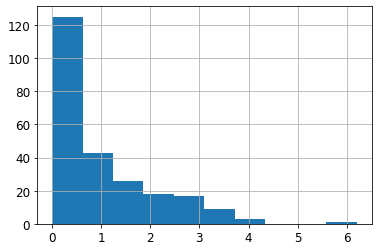

In [88]:
#en baştaki pairplotta Oldpeak alanında bi skewness var görünüyordu
X_train.Oldpeak.hist();

Ancak burdaki veriler kesikli(discrete) olduğu ve sayısı çok az olduğu için log transformasyona çok uygun değil. O yüzden bu aşamayı es geçebiliriz.

### Scaling

Maaş(4-5 basamaklı) ve yaş(2 basamaklı) gibi iki farklı ölçekteki verinin aynı ölçeğe getirilme işlemidir. Özellikle distance hesabı yapan algoritmalar için kritik öneme sahiptir. Bazı algoritmalar distance hesabı yapmadığı için(tree-based olanlar gibi) onlarda yapılmasa da olur. Nihai pipeline içinde, yapıldığı ve yapılmadığı iki senaryo denenebilir. Bununla birlikte özellikle optimizer olarak GradientDescent veya solver olarak saga kullanan algoritmaların daha hızlı converge etmesi için her halükarda yapılmasında fayda olabilir, zaten çok da yorucu bir işlem değildir.

3 türü vardır.

- StandartScaling: Ortalaması 0, standart sapması 1 olan bir dağılıma döndürür. **Datanın normal dağılıma uygun olması lazımdır.**. Aksi halde ya MinMax kullanılmalı ya da öncesinde Log transformasyon uygulanmalıdır.

- MinMaxScaling: Verileri 0-1 arasında sıkıştır. Ama bunun bi bedeli vardır. **Data çok sıkıştığı için variance düşer.** Halbuki iyi bir model için featurelarda görece yüksek variance bekleriz. StandarScalerin iyi çalışmayacağı caseler için iyi sonuçlar üretebilir, mesela normal dağılıma uygun değilse. Outlierlara duyarlıdır, yani bu uygulansa bile outlierların relative etkisi devam eder.(Buna, hatta bazen üsttekine bazen yanlışlıkla normalization da denir, ama bu hatalı bi kullanımdır. Nedeni için <a href="https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02">buraya</a> bakabilirsiniz). 

- Robust Scaler: MinMaxScaler'a benzer ama alt-üst sınır olarak min-max yerine IQR değerlerini kullanır, bu yüzden **outlierlara dayanıklıdır**.

Yine mümkünse girdsearchte hepsini ayrı ayrı deneyip en uygun olanı bulmaya çalışmak gerekebilir.

**Önemli hususlar**

- Ordinal ve Onehot encoding yapılmış kolonlarda scaling yapılıp yapılmaması yönünde bi görüş ayrılığı sözkonusu, o yüzden ikisini(yap-yapma) de deneyip görmek lazım.
- Regression durumunda, sadece X'ler scale edilir, y'ler edilmez.

In [89]:
X_train[nums].describe()

,Age,RestBP,Chol,MaxHR,Oldpeak,Ca
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,54.909091,131.946281,248.365186,149.867769,0.971074,0.694215
std,9.064545,16.802774,49.074433,23.120447,1.115075,0.962733
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,136.000000,0.000000,0.000000
50%,56.000000,130.000000,243.500000,152.500000,0.600000,0.000000
75%,61.000000,140.000000,277.750000,167.750000,1.600000,1.000000
max,77.000000,170.000000,377.875000,202.000000,6.200000,3.000000


Scaling ihtiyacı var görünüyor. Featurelarımız normal dağılıma uygun gibi göründüğü için standartscaler ile ilerleyebiliriz. Tabi yine zaman problemi yoksa diğerlerini de gridsearch içinde deneyebilirsiniz. 

Bir diğer konu da Ordinal ve onehot encode edilmiş featureların da yine scalinge tabi tutulması olabilir. Biz burdaki manuel işlemde bunları da işleme tabi tutacağız.

In [91]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_train[0]

array([ 1.33663279,  0.56304034,  1.19595024,  0.58470692, -1.04441093,
        0.95924191, -0.87266506,  0.31828031, -1.39686059, -0.43159531,
       -0.68313005, -0.92050434, -0.2284161 ,  0.89027669, -0.79003865])

**Kaynaklar**

- https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
- https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re
- https://statisticsbyjim.com/regression/standardize-variables-regression/
- http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
- https://medium.com/towards-artificial-intelligence/feature-scaling-with-pythons-scikit-learn-10ab42119ae0 

### Imbalanced data durumunda ovesampling/undersampling 

Bizim datasetimizde bir imbalanace durumu olmadığı için bu aşamayı es geçiyoruz. Ama böyle bir örneği <a href="../Sample%20Projects/Imbalanced%20Data.ipynb">şurada</a> bulabilirsiniz.

### Dimension reduction

Çok fazla kolon olması sorununu(Curse of dimensionality) bazen feature selectiona göre daha farklı yöntemlerle çözeriz. Mesela varolan featurelar az sayıdaki isimsiz featurelara sıkıştırılır. Dolayısıyla yorumlamayı zorlaştırır ama model performansına katkıda bulunabilir(bulunmayabilir de)

PCA gibi dimension reduction yöntemleri aslında yeni featurelar yaratmaları bakımından feature extraction olarak da görülmektedirler.

Bizim veri setimizde çok fazla kolon yok, o yüzden uygulamasak da olur, ama yine de tecrübe etmiş olmak için uygulayacağız, fakat nihai pipeline içinde kullanmayacağız. Konunun detayları için ilgili notebookumu <a href="../Unsupervised/Dimensionality%20Reduction.ipynb">şurada</a> bulabilirsiniz.

**Dikkat edilecek hususlar**

- Scaling yapılmış olması gerekiyor, sıralama önemli.
- Sadece numerik kolonlara yapılacaktır.

In [92]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

In [93]:
X_train_pca[0]

array([-1.6152172 ,  1.73987438,  0.63628478])

In [94]:
pca.explained_variance_ratio_.sum()

0.43930454703104677

Eldeki verinin varyansını düşürdüğümüz yani bilgi kaybına uğradığımız için accuracy düşecek gibi gelebilir size ama durum her zaman öyle değil, zira PCA'in amacı sadece training süresini düşürmek değil aynı zamanda overfittingi de engellemek. Böylece aslında daha iyi sonuç bile alabiliriz. Gridsearch sırasında bunun uygulandığı ve uygulanmadığı iki durum için de bakılabilir.

Bu arada, n_components parametresine direkt istediğimiz varyansı da verebiliriz, böylece n_component adedi de ona göre değişecektir.

In [95]:
pca=PCA(n_components=0.90)
X_train_pca2 = pca.fit_transform(X_train)
pca.n_components_

11

Toplam feature sayısının sadece 2 adet azalmasını sağladı. Bunun böyle olacağını EDA bölümündeki pairplottaki scatter diagramlardan da anlayabilirdik aslında. Zira orda featureların hiçbiri birbiriyle korele görünmüyordu, dolayısıyla high dimensiondaki bu featureları low dimensiona indirirken bi sıkıştırma yapmasını bekleyemezdik.

Biz modellerimizde en son scale edilmiş halini kullanacağız, yani X_train'i.

# Modelleme

## Model Selection ve Validation

Buraya kadar geldiğimize göre, eğitim setinin tüm datasetle yapılmayacağını, **sadece eğitim seti** ile yapılacağını biliyor olmanız lazım. Zaten preprocessing öncesinde test setimizi ayırmıştık. Duruma göre biraz çeşitlenmekle birlikte süreç özetle şöyle işleyecek:

- **Model Selection**: En iyi parametre seçiminin yapılacağı **geçici eğitim** aşamasıdır. Burada **test datası ile ilgili bi işlem yapılmaz**. Train datası uygun bir yöntemle farklı seçeneklerle eğitilir ve uygun model seçilir. Farklı seçenekten kastım tek bir algoritmanın farklı parametreleri olabileceği gibi farklı algoritmalar da olabilir.

- **Model Validation**: Gerçek hata payımız nedir sorusunun cevabını almaya çalışırız. Model seçiminden sonra test datasının performansına bakılır.

- **Model Evaluation**: Çeşitli metriklerle modelin nihai performansını ölçeriz. Başarılı değilsek başa dönülür, başarılıysak final model tüm data üzerinden son birkez daha eğitilir.

- **Final model training**: Nihai modele karar verildiğinde uygun parametrelerle **tüm veri seti** tekrar eğitilir.

- **Deployment**: Modelimizi production ortamına deploy ederiz.

İşin özünde elimizdeki datayı farklı yöntemlerde 3 kısma ayırıyoruz. `train, validation, test`. Bunların amacı şöyle:

1. Train seti eğitim için kullanılır.
2. Validation seti farklı modeller ve parametreler arasından uygun model seçimi için kullanılır. A modeli mi B modeli mi, A ise, bunun x parametresi kaç olsun y parametresi kaç olsun gibi.
3. Test seti de seçtiğimiz model genel olarak ne kadar iyi onu test etmek için kullanılır.

Başka bir bakış açısıyla aslında 4 tür yaklaşım var diyebiliriz.

1. Evaluation with hold-out data (çok büyük veri setlerinde)
2. Hold-out validation with a test set (aslında bu da 1-fold cross validation)
3. k-fold Cross validation
4. Nested Cross Validation

Şimdi yukarda bahsettiğimiz 4 yaklaşıma bakalım. Öncesinde aşağıdaki videoyu da izleyebilirsiniz.

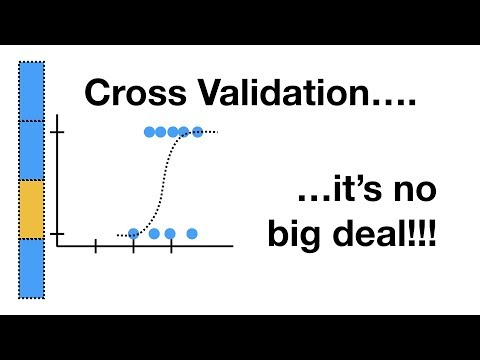

In [96]:
from IPython.display import YouTubeVideo
YouTubeVideo("fSytzGwwBVw")

### 1.yöntem:Hold-out datası ile validation

Burda eğitim işlemi, tüm train datası ile 1 kere yapılır. Genelde çok büyük veri setlerinde bu kullanılabilir. Diğer durumlarda diğer yöntemlerin kullanılması tercih edilmelidir.

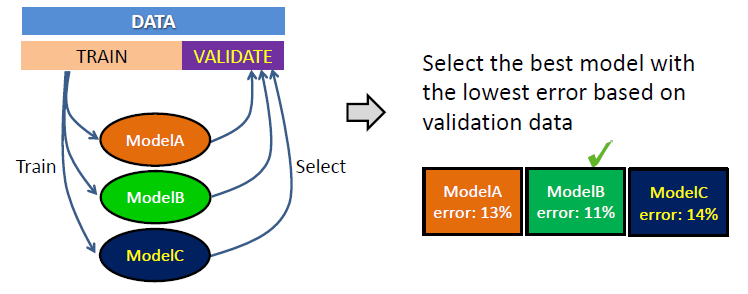

Aşamaları şöyledir:

1. Verisetini eğitim ve test(validation da denebilir) olmak üzere iki parçaya bölün
2. Her bir parametre kombinasyonu için eğitim setini eğitin ve test seti üzerinde başarı metriğini hesaplayın
3. En iyi sonucu veren hyperparametre setini belirleyin
4. Bu parametrelerle tüm veri seti üzerinden yeniden eğitin

Bu noktada durup, eğer hala bakmadıysanız, öncelikle <a href="Logistic%20Regression.ipynb">buradan</a> Logistic regresyon notebookuma bakmanızda fayda var, sonra tekrar gelin, devam edelim.

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C = 1, solver='lbfgs')
lr.fit(X_train, y_train) #sadece fit ederiz, trasnform yok, bi değişkene atama yok
y_pred = lr.predict(X_train) #eğitilmiş modeller tahminlelrimizi yaparız
print(lr.score(X_train,y_train)) #veya accuracy_score(y_train,y_pred) 

0.8512396694214877


Bu skor, `training accuracy` olarak geçer. Sonrasında bir de test seti üzerinde aynı tahminlemeyi yapabiliriz. Küçük veri setleri için bu casede şöyle bir problem var tabi: ya ayırdığımız validation set çok şanslı bir setse, tesadüfen başarı skoru yüksek çıktıysa? Çözüm olarak, validation sete ek olarak bir de nihai test seti ayırmak önerilir.

Bu ilk yöntem hemen hemen hiç uygulanmaz, eldeki veriseti çok büyükse uygulanabilir denir ama pratikte ben kimsenin bu şekilde ilerlediğini görmedim, ille de bi cross validation yapılır.

### 2.yöntem: cross validation(validation ve test set ayrım) 

Bunda test seti bi kenara koyduktan sonra, train setimizi de kendi içinde sub-train ve validation olmak üzere ikiye ayırıyoruz. Yani elimizde toplamda 3 set oluyor.

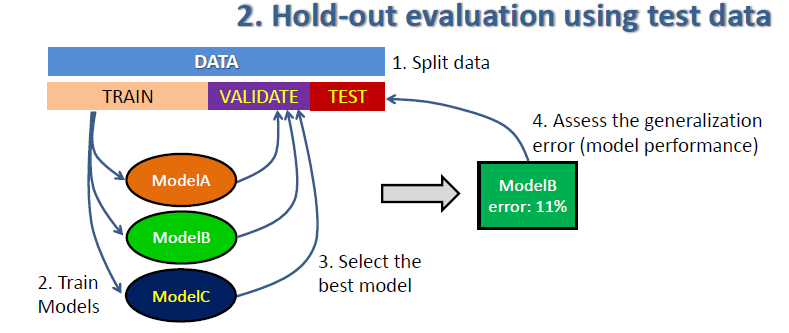

Şimdi elimizde daha iyi bir model seçici yöntemimiz var, oluşacak performans skoru da daha genelleştirilmiş bir skor olacak. Ama ilk yöntemdeki problem kısmen yine devam ediyor gibi. Ya burda da validation setinde yine şanslı bir bölme yaptıysak? Büyük veri setinde bu olasılık yine düşük, çünkü veriseti o kadar büyüktür ki, bölmeyi yaptığımızda her alt parçada ana kümeyi temsil kabiliyeti yüksektir. Ama küçük verisetlerinde problem olasılığı var. O zaman çözüm k-fold cross validation yapmakta.

Bunun kodlamasını yapmaya gerek yok, ana datamızı nasıl train ve test diye ikiye bölmüştük, şimdi de X_train'i bir daha kendi içinde train ve test diye iki kısma ayırdıktan sonra 1.yöntemin aynısı yapılır.

### 3.yöntem: k-fold cross validation

Bunda ise eğitim setini birden çok(k) kez farklı random splitlerle ayırıp o kadar çalıştırıp ortalamsına bakıyoruz.

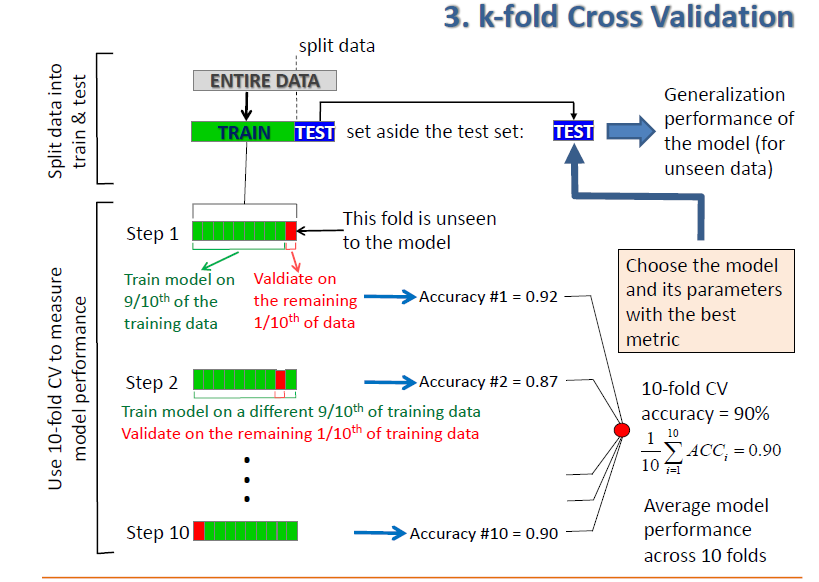

Bu yukarıdaki gösterimde bir de outer loop düşünebilirsiniz. Diyelim ki 3 ayrı modeliniz var, her biri için tek bir parametre setiyle 10 fold cv yapıyorsunuz, her birinin ortalamasını alıp, bu 3 modelden en büyük ortalamayı seçeriz. Böyle bir durumda toplamda 30 kez model çalışmış olur. Tabi en yüksek ortalamalı modelde cv sonuçlarının standart sapmasına bakmak gerekir; ortalamaya göre yüksek bir standart sapma varsa, yani her bir foldun model sonuçlarında dalgalanma varsa, bu modele güvenmemek gerekir.

Tek bir modelin farklı parametrelerine de bakmış olabiliriz. Gridsearch ile toplam 120 farklı kombinasyona bakılabilir, bunu 10 kez yapınca 1200 kez model çalışmış olur. Yine en iyi seçeneğin cv sonuçlarının standart sapmasına bakarız.

Tek bir modelin tek bir parametre setine de bakılabilir. O zaman toplam 10 kez çalışmış olur. Keza burda da yine en iyi seçeneğin cv sonuçlarının standart sapmasına bakarız.

Standart sapma konusunu açacak olursak, 10 fold'un skorlarını birbirinden çok da farklı olmamasında fayda var. Biri %60larda kalanı %90 civarında olmamalı. Aslında olursa da çok büyük bi sorun yok, zaten bunların ortalamasını alırız ve 60lık skor ortalamayı düşürecek ve biz de diyeceğiz ki, sahadan gelen veriyi tahminleme beceresi %87((9\*90+60)/10) civarı olacak. Ama yine de dalgalanma varsa şüpheyle yaklaşmak gerekir.

Özetle, cross validation'ı daha önceki bir <a href="https://mvolkanyurtseven.medium.com/makine-%C3%B6%C4%9Frenimi-felsefesi-3-986fb6ff0710">gönderimde</a> belirttiğim gibi, overfit edip etmediğini anlamak için yapıyoruz.(Bazı kaynaklarda belirtildiği gibi overfittingi engellemek için değil.)

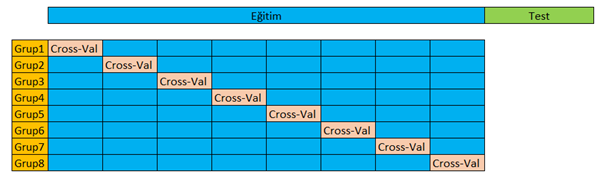

Burda her bir fold için başarı oranı 90,92,89 gibi 90 civarında dalgalanabilir ve ortalaması 90 çıkabilr. Biz de biliriz ki, modelimizin ortalama training accuracyci 90 civarı olacak. Halbuki tek bir fold ile baksaydık belki tesadüfen 93 çıkacaktı. Sonra bir de test setiyle bakıp, orda da 88 gibi birşey görürsek kısmen overfit ediyor derdik, çünkü train ve test arasında fark var ama aslında 93ten 88'ee değil, 90dan 88e düşmüş, yani o kadar da yüksek bi overiftting yok.

Bu arada iterasyonlardan biri 44 gibi bir accuracy’e sahipse veya birbiriyle alakasız oranlar varsa modelimizde sorun var demektir. Model tam öğrenemiyordur veya verimiz çok karmaşıktır, bizim de modelimizdeki kompleksliği artırmamız gerekmektedir. Bu noktada gerçek test seti(yeşil) üzerinde denemeye geçmeyiz bile. Yapacağımız şey, modelimizi düzeltmek olmalıdır. Nasıl düzelteceğmize biraz ileride bakacağız.

k, genelde 3,5,10 gibi bi değer seçilir. Verimiz çok büyükse 3 yeterlidir, yoksa 10a kadar çıkılabilir. Şimdi kodlamasına bi göz atalım.

In [98]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train, y_train, cv=3, scoring='accuracy')
print(scores)
scores.mean(), scores.std()

[0.79012346 0.87654321 0.8375    ]


(0.8347222222222221, 0.03533535026868965)

Farkettiyseniz modelin fit metodunu kullanmadık, cross_val_score bunu internal olarak yapıyor. Bundan sonraki aşamalarda da modelin kendisini doğrudan fit ettirmeyeceğiz.

Sonuçlara gelecek olursak, dalgalanma var gibi ama ortalama perf %82 olcak diyebiliriz. Peki logistic regresyon modelinin C parametresinin farklı değerleri için denesek sonucumuz ne olurdu, ona bakalım.

In [99]:
cv_scores = [] ; training_scores = []
c_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
for c in c_range:
    print("c=",c,"için değerler")
    Clf = LogisticRegression(C = c, solver='lbfgs') # default penalty = l2 used
    scores = np.round(cross_val_score(Clf, X_train, y_train, cv=3, scoring='accuracy'),2)
    cv_scores.append(scores.mean())
    print(f"Skorlar:{scores}, ortalama skor: {scores.mean()*100:.2f}%, skor std:{scores.std():.2f} ",end="\n\n")    

c= 0.001 için değerler
Skorlar:[0.73 0.65 0.71], ortalama skor: 69.67%, skor std:0.03 

c= 0.01 için değerler
Skorlar:[0.78 0.86 0.81], ortalama skor: 81.67%, skor std:0.03 

c= 0.05 için değerler
Skorlar:[0.79 0.88 0.8 ], ortalama skor: 82.33%, skor std:0.04 

c= 0.1 için değerler
Skorlar:[0.81 0.88 0.8 ], ortalama skor: 83.00%, skor std:0.04 

c= 0.2 için değerler
Skorlar:[0.8  0.89 0.82], ortalama skor: 83.67%, skor std:0.04 

c= 0.3 için değerler
Skorlar:[0.8  0.88 0.82], ortalama skor: 83.33%, skor std:0.03 

c= 0.5 için değerler
Skorlar:[0.79 0.88 0.82], ortalama skor: 83.00%, skor std:0.04 

c= 1 için değerler
Skorlar:[0.79 0.88 0.84], ortalama skor: 83.67%, skor std:0.04 



Tekrar etmekte fayda var, burdaki skorlar modelin genel performansı değildir, şuan hala training set üzerinde çalışıyoruz ve sadece en uygun parametre setini seçmeye çalışıyoruz. Bu parametrelerle test set üzerinde de çalışıp o zaman model performansını elde edeceğiz ve bu skorları karşılaştıracağız.

Peki sadece C değil başka parametreler için de en iyi değeri bulmaya çalışsaydık? Bunun cevabı **GridSearch**'te. Birazdan oraya da geliyoruz.

**Repeated cv**

Devam edelim, cv yerine bi rakam yazılabileceği gibi, oraya bi cv iterator de konulabilir. Mesela **RepeatedKFold**. Bu, KFold'u n kere yapmaya yarar ve bu da generalization performansımızı daha da gerçekçi hale getirir. Eğer verisetimiz imbalanced olsaydı o zaman da **StartifiedRepeteadKfold** yapardık. Veriseti büyüklüğüne göre değişmekle birlikte küçük-orta bi verisetinde 100 repeat, 10 fold yapılabilir. Biz basit olsun diye 5-10 yapalım.

In [100]:
from sklearn.model_selection import RepeatedKFold
mycv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
model = LogisticRegression(C=1, solver='newton-cg')
scores = np.round(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=mycv, n_jobs=-1,verbose=1),2)
print(f"Skorlar:{scores}, ortalaması: {np.round(scores.mean(),2)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s


Skorlar:[0.92 0.73 0.88 0.75 0.83 0.78 0.82 0.9  0.83 0.83 0.82 0.8  0.9  0.85
 0.81 0.73 0.86 0.83 0.79 0.9  0.86 0.86 0.77 0.88 0.81 0.78 0.86 0.79
 0.85 0.88 0.82 0.84 0.83 0.81 0.88 0.71 0.8  0.92 0.9  0.79 0.86 0.82
 0.85 0.88 0.81 0.8  0.8  0.75 0.85 0.92], ortalaması: 0.83


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.7s finished


Peki, cv prosedürünü en iyi modeli seçmek için, test setini de genelleştirilmiş performansı ölçmek için kullanıyoruz dedik. k-fold ile validation setteki varyans sorununu çözdük, hatta bunu repeated yaparak model stabilitesini de daha iyi ölçtük, güzel. Ama elimizde sadece bir tane test set var. Peki ya bu test setindeki varyans sorunu ne olacak? Validationda yaptıklarımızı onda da yapmak lazım değil mi? Lazım. Zira farklı bir test seti ile farklı bir generalization performansı elde edebiliriz. Bununu çözümü de **Nested Cross Validation**da.

### 4.yöntem: Nested k-fold cross validation

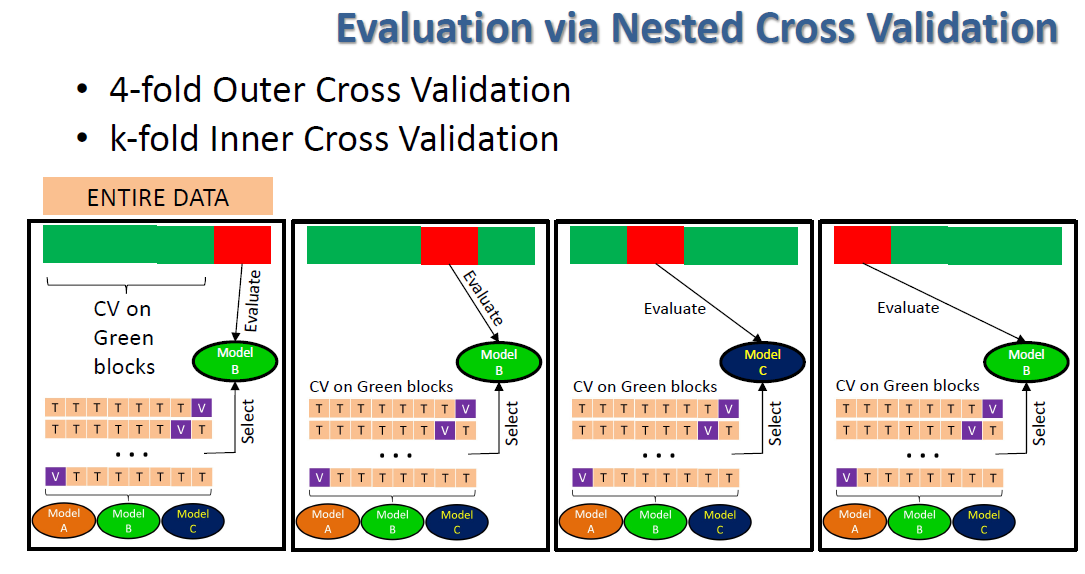

Tahmin edeceğiniz üzere, bu işlem toplam model çalıştırma süresini daha da uzatır. O yüzden büyük veri setlerinde yapmak mantıklı olmaz. Bunun da implementasyonuna girmeyeceğiz, ancak <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html">şurada</a> bir kod örneği bulabilirsiniz.

### GridSearchCV ve RandomizedSearchCV

En iyi hyperparametre kombinasyonunu bulmak için uygulanan yöntemlerdir.

#### GridSearch

Grid searchte, tüm parametreler bir gride yazılır. Modelin parametreleri bir dictionary şeklinde belirtilir. Birden fazla değer girilecekse, ki grid kullanmanın esas sebebi budur, bunları list şeklinde gireriz. 

Grid tamamlandıktan sonra model değil grid nesnesi fit edilir. Bu da aslında arka planda her bir kombinasyon için modeli fit eder. Gridsearch kendi içinde cross validation da yapar, bu nedenle bi cv parametresi vardır, cross_val_score'da olduğu gibi bir sayı girebilir veya bi cv iterator yaratıp onu atayabiliriz.

In [101]:
from sklearn.model_selection import GridSearchCV
params = {
           'C'      : c_range, 
           'penalty': ['l2'], #tek değer olsa bile list olarak verilmeli
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
         }  
         
clf = LogisticRegression(max_iter=1000) #sabit olan parametreler direkt bu satırda yazılabilir
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
grid = GridSearchCV(estimator = clf, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

grid.fit(X_train, y_train)

Fitting 15 folds for each of 40 candidates, totalling 600 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=1)

LogisticRegression'ın dokümantasyonuna göre penalty parametresinin l1 olması durumunda sadece liblinear solver'ı kullanabiliyormuşuz. O yüzden aşağıdaki gibi bir **list of dictionary** vererek işimizi görürüz.

In [102]:
%%time
params = [{'C'      : c_range,
           'penalty': ['l1'], 
           'solver' : ['liblinear']},
          
          {'C'      : c_range, 
           'penalty': ['l2'], 
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
         ]

clf = LogisticRegression(max_iter=1000) #sabit olan parametreler,max_iter gibi, direkt bu satırda yazılabilir
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
grid = GridSearchCV(estimator = clf, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

grid.fit(X_train, y_train)

Fitting 15 folds for each of 48 candidates, totalling 720 fits
Wall time: 3.32 s


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
                          'penalty': ['l1'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             scoring='accuracy', verbose=1)

GridSearch içinde kaç model çalışacağını şöyle hesaplayabilirsiniz:

$$\sum_{i=1}^d\prod_{j=1}^t {len(V_j)} . n\_splits . n\_repeats$$

Burada, d=params içindeki dictionary sayısı, t=bir dictionary içindeki item sayısı, V de dictionarydeki Value'lar, yani ilgili parametrenin alacağı değerlerin listesi oluyor. Bu hesaba göre;

(8x1x1 + 8x1x5)=48 --> 48x3x5=720

In [103]:
grid.best_estimator_ #refit=True olduğu için şuan elimizde bir estimator var

LogisticRegression(C=0.05, max_iter=1000, solver='newton-cg')

In [104]:
y_pred = grid.predict(X_train) #refit=True olduğu için şuan elimizde bir estimator var, ve predict edebiliyoruz
print(grid.score(X_train,y_train)) #refit edilmiş modelin tüm train datası üzerindeki nihai skoru

0.8429752066115702


In [105]:
grid.best_params_

{'C': 0.05, 'penalty': 'l2', 'solver': 'newton-cg'}

In [106]:
#validation setlerinin ortalama skoru
grid.best_score_

0.8239609053497943

best_score_ attribute'ü ve score metodu sonuçları farklı, yanlarına açıklama yazdım ama isterseniz <a href="https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score">şuraya</a> da bakabilirsiniz.

In [107]:
#skorlara bakalım, en yüksek olanı da kırmızı renkli gösterelim
from colorama import Fore #renkli text için
cvres = grid.cv_results_
for params,mean_score in zip(cvres["params"],cvres["mean_test_score"]):
    if mean_score==grid.best_score_:
        print(Fore.RED + f"{params} parametreleriyle sonuç: {mean_score:.3f}")
    else:
        print(Fore.RESET + f"{params} parametreleriyle sonuç: {mean_score:.3f}")

{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.546
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.546
{'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.803
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.809
{'C': 0.2, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.817
{'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.820
{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.817
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} parametreleriyle sonuç: 0.816
{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'} parametreleriyle sonuç: 0.687
{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'} parametreleriyle sonuç: 0.687
{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'} parametreleriyle sonuç: 0.819
{'C': 0.001, 'penalty': 'l2', 'solver': 'sag'} parametreleriyle sonuç: 0.687
{'C': 0.001, 'penalty': 'l2'

veya şöyle bir dataframede göstermek daha şık olacaktır.

In [108]:
ml.gridsearch_to_df(grid)    

,param_C,param_penalty,param_solver,mean_test_score,std_test_score
22,0.05,l2,saga,0.823961,0.039644
21,0.05,l2,sag,0.823961,0.039644
19,0.05,l2,lbfgs,0.823961,0.039644
18,0.05,l2,newton-cg,0.823961,0.039644
20,0.05,l2,liblinear,0.823128,0.034555


NOT:Bu gridsearch olayının bir tık ilerisi, olası tüm algoritma türleri için model çalıştırmaktır. Bunlara **`Auto ML`** yaklaşımı deniyor. Vaktim olursa bir ara böyle bi çalışma da yapacağım.

#### RandomizedSearch

İlk başlarda çok deneyiminiz yokken, gridsearchte gride ne yazacağınızı bilmeyebilirsiniz. Hele hele neural network'lerde göreceğimiz gibi hyperparametre sayısı çok ise ilk başta **RandomizedSearch** kullanmak daha akıllıca olacaktır.

Burada tüm kombinasyonlar denenmez, sadece bir kombinasyon denenir. Parametre uzayını da geniş tutarak rasgeleliği iyice sağlama alırız. Bunun için olası değerleri tek tek girmek yerine aralık fonkisyonlarından yararlanırız. GridSearchten farklı olarak burada, verilen değerlerden sadece biri rasgele seçilir, ama bu işlem n_iter paramtersindeki rakam kadar tekrarlanılır.

In [109]:
%%time
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
params = {
           'C'      : np.hstack((np.random.randint(1,100,size=10),np.random.rand(1,10)[0])), #burdaki 20 farklı değerden rasgele biri seçilecek
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #burdaki 4 farklı değerden rasgele biri seçilecek
         }  
         

clf = LogisticRegression(penalty="l2",max_iter=1000)
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
rs = RandomizedSearchCV(estimator = clf, n_iter=10, param_distributions = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

rs.fit(X_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Wall time: 1.09 s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
                   estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                   param_distributions={'C': array([5.20000000e+01, 9.30000000e+01, 1.50000000e+01, 7.20000000e+01,
       6.10000000e+01, 2.10000000e+01, 8.30000000e+01, 8.70000000e+01,
       7.50000000e+01, 7.50000000e+01, 8.66176146e-01, 6.01115012e-01,
       7.08072578e-01, 2.05844943e-02, 9.69909852e-01, 8.32442641e-01,
       2.12339111e-01, 1.81824967e-01, 1.83404510e-01, 3.04242243e-01]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='accuracy', verbose=1)

In [111]:
ml.gridsearch_to_df(rs)

,param_solver,param_C,mean_test_score,std_test_score
5,liblinear,0.832443,0.820617,0.041491
0,lbfgs,0.866176,0.819794,0.042204
6,newton-cg,0.708073,0.819784,0.042018
7,lbfgs,0.601115,0.818128,0.041003
4,saga,0.304242,0.817315,0.039361


#### Önemli hususlar

- Kodların hızlı çalışması için paralel işlem gücünden yararlanılabilir. Bunun için `n_jobs` parametresine -1 denir, böylece çalışılan bilgisayardaki tüm core'lar kullanılır. İsterseniz buraya core sayısından daha küçük bir değer de yazabilirsiniz.
- `refit=True` denirse, en iyi parametrelere göre model çalıştırılıp ilgili değişkene atanır, böylece en uygun parametrelere göre tekrardan çalıştrma derdi olmaz, özellikle uzun çalışan bir model ise.
- Tahmin edileceği üzere Gridsearch çok maliyetli bi işlemdir. Kullanılan değerlere göre sadece tek bir algoritma için birkaç bin farklı model çalışabilir. Bir de farklı algoritmalar denediğinizi düşünün, sayı iyice artar. Burda şu öneriliyor, mesela 3 farklı algoritma için özellikle sabit rakam girilen parameterelere az sayıda değer vererek([1,2,3,4,5,6,7,8,9,10] değil de [1,5,10] girmek gibi) gridsearch yapmak, sonra en iyi model hangisiyse onu seçip bu sabit değerlerden de hangisi en iyi çıktıysa onun etrafındaki rakamlardan birkez daha sadece şampiyon algoritmayı çalıştırmak(az önceki rakamlarda 5 çıktı diyelim, [3,4,5,6,7] vermek gibi). Hatta bazı parametrelerde ardışık vermek yerine, exponansiyel verin, sonra en iyisinin etrafında ardışık verebilirsiniz. Ör: [0.1, 0.2,0.3....0.9, 1] yapmak yerine  0.001, 0.01, 0.1 ve 1 diyip atıyorum bunlardan en iyisi 0.1 çıkarsa, sonra 0.1, 0.2, 0.3 verebiliriz.<br><br>
Tabi burda en ideali şu, 3 algoritma yerine belki 7-8 algoritma çalıştırıp 3 tanesini şampiyon seçmek ve bunlara bu ince ayarı yapmak, sonra bu 3ünü de ileride göreceğimiz gibi Ensemble bir modele(ör:VotingClassifer) sokmak olacak.
- Bunların **halving** versiyonu da var, ki **çok daha hızlı** search yapılmasını sağlar, aşağıda bunları göreceğiz.
- scoring parametresi için <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">f1 türevleri</a> verileceği zaman <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html">make_scorer</a> fonksiyonundan yaralanılır. Bunun bir örneğini Part II'da yapacağız. Ör: make_scorer(f1_score , average='macro')
- https://github.com/hyperopt/hyperopt adresinde ise bu işte özelleşmiş başka bir kütüphane bulunuyor.

#### Adım adım GridSearch

Yukarıdaki verdiğimiz ipuçlarından faydalanıp, C paramtresinin en uygun değerlerine adım adım yaklaşmayı deneyelim.

In [112]:
#ilk olarak şu değerleri verelim
np.set_printoptions(suppress=True)
newCrange=np.logspace(4,-5, num=10)
newCrange

array([10000.     ,  1000.     ,   100.     ,    10.     ,     1.     ,
           0.1    ,     0.01   ,     0.001  ,     0.0001 ,     0.00001])

In [113]:
%%time
params = [{'C'      : newCrange,
           'penalty': ['l1'], 
           'solver' : ['liblinear']},
          
          {'C'      : newCrange, 
           'penalty': ['l2'], 
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
         ]

clf = LogisticRegression(max_iter=1000) #sabit olan parametreler direkt bu satırda yazılabilir
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
grid = GridSearchCV(estimator = clf, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

grid.fit(X_train, y_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits
Wall time: 4.49 s


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': array([10000.     ,  1000.     ,   100.     ,    10.     ,     1.     ,
           0.1    ,     0.01   ,     0.001  ,     0.0001 ,     0.00001]),
                          'penalty': ['l1'], 'solver': ['liblinear']},
                         {'C': array([10000.     ,  1000.     ,   100.     ,    10.     ,     1.     ,
           0.1    ,     0.01   ,     0.001  ,     0.0001 ,     0.00001]),
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             scoring='accuracy', verbose=1)

In [114]:
grid.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [115]:
grid.best_score_

0.8231172839506172

C için en iyi değer 0.1 çıktığına göre, artık 0.1 civarında yeni ince ayar yapabiliriz.

In [116]:
%%time
params = [{'C'      : [0.05, 0.07, 0.1, 0.12, 0.15],
           'penalty': ['l1'], 
           'solver' : ['liblinear']},
          
          {'C'      : [0.05, 0.07, 0.1, 0.12, 0.15], 
           'penalty': ['l2'], 
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
         ]

clf = LogisticRegression(max_iter=1000) #sabit olan parametreler direkt bu satırda yazılabilir
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
grid = GridSearchCV(estimator = clf, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

grid.fit(X_train, y_train)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Wall time: 1.64 s


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': [0.05, 0.07, 0.1, 0.12, 0.15], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.05, 0.07, 0.1, 0.12, 0.15], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             scoring='accuracy', verbose=1)

In [117]:
grid.best_params_

{'C': 0.05, 'penalty': 'l2', 'solver': 'newton-cg'}

In [118]:
grid.best_score_

0.8239609053497943

C'yi 0.1'den 0.05'e çekmek performansta küçük de olsa bir artış sağladı.

#### Halving GridSearch

Normal GridSearch tüm dataya bakarken bu yaklaşımda datanın belli bi subsample'ına bakılıyor. Çıkan sonuçlara göre en yüksek skoru veren adaylar(sayısı, mevcudun yarısı kadar) ilk subsampleın belli bir katı kadar(factor) data üzerinde tekrar eğitiliyor, taki en iyi sonuç bulunana kadar.

Parametreler içindeki "resource" geçen şeyler aslında elimizdeki subsample'ı gösteriyor. Tüm proses, **factor ve min_samples** seçimleriyle kontrol ediliyor. Bunların nasıl seçilmesiyle ilgili, üstelik ilgili algoritmaları da açıklayan çok güzel bir yazıyı <a href="https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155">şurada</a> bulabilirsiniz.

In [119]:
%%time
from sklearn.experimental import enable_halving_search_cv #önce bunu çalıştırmak lazım
from sklearn.model_selection import HalvingGridSearchCV

params = [{'C'      : c_range,
           'penalty': ['l1'], 
           'solver' : ['liblinear']},
          
          {'C'      : c_range, 
           'penalty': ['l2'], 
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}  
         ]

clf = LogisticRegression(max_iter=1000) #sabit olan parametreler direkt bu satırda yazılabilir
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
grid_h = HalvingGridSearchCV(estimator = clf, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 

grid_h.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 60
max_resources_: 242
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 60
Fitting 15 folds for each of 48 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 16
n_resources: 180
Fitting 15 folds for each of 16 candidates, totalling 240 fits
Wall time: 3.36 s


HalvingGridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
                    estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                    param_grid=[{'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5,
                                       1],
                                 'penalty': ['l1'], 'solver': ['liblinear']},
                                {'C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5,
                                       1],
                                 'penalty': ['l2'],
                                 'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']}],
                    scoring='accuracy', verbose=1)

Süre anlamında çok büyük bi fark olmamış gibi görünüyor ancak, daha büyük bir parametergrid içinde bu fark hissedilebilir düzeye gelecektir. Part II'de bunu göreceğiz. Ama performans sonucu olarak hemen hemen aynı sonuçları elde edebiliyoruz.

In [121]:
ml.gridsearch_to_df(grid_h)

,param_C,param_penalty,param_solver,mean_test_score,std_test_score
15,0.01,l2,liblinear,0.830000,0.077458
10,0.001,l2,liblinear,0.826667,0.079721
49,0.3,l2,liblinear,0.824463,0.044376
60,0.1,l2,liblinear,0.823390,0.048220
50,0.2,l2,liblinear,0.820019,0.044516


#### Halving RandomizedSearch

In [122]:
%%time
from sklearn.experimental import enable_halving_search_cv #önce bunu çalıştırmak lazım
from sklearn.model_selection import HalvingRandomSearchCV
np.random.seed(42)
params = {
           'C'      : np.hstack((np.random.randint(1,100,size=10),np.random.rand(1,10)[0])), #burdaki 20 farklı değerden rasgele biri seçilecek
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #burdaki 4 farklı değerden rasgele biri seçilecek
         }  
         

clf = LogisticRegression(penalty="l2",max_iter=1000)
mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
rs_h = HalvingRandomSearchCV(estimator = clf, param_distributions = params, cv = mycv, n_jobs=-1, verbose = 1, 
                           scoring = 'accuracy') 

rs_h.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 60
max_resources_: 242
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 60
Fitting 15 folds for each of 4 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 2
n_resources: 180
Fitting 15 folds for each of 2 candidates, totalling 30 fits
Wall time: 741 ms


HalvingRandomSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=1),
                      estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                      param_distributions={'C': array([52.        , 93.        , 15.        , 72.        , 61.        ,
       21.        , 83.        , 87.        , 75.        , 75.        ,
        0.86617615,  0.60111501,  0.70807258,  0.02058449,  0.96990985,
        0.83244264,  0.21233911,  0.18182497,  0.18340451,  0.30424224]),
                                           'solver': ['newton-cg', 'lbfgs',
                                                      'liblinear', 'sag',
                                                      'saga']},
                      scoring='accuracy', verbose=1)

In [124]:
ml.gridsearch_to_df(rs_h)

,param_solver,param_C,mean_test_score,std_test_score
4,lbfgs,0.866176,0.821111,0.046050
5,saga,0.020584,0.800998,0.037730
1,saga,0.020584,0.779649,0.108628
0,lbfgs,0.866176,0.776491,0.131201
2,lbfgs,83.0,0.766491,0.117823


### Kaynaklar

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/grid_search.html
- https://stats.stackexchange.com/questions/152907/how-do-you-use-the-test-dataset-after-cross-validation
- https://stats.stackexchange.com/questions/410118/cross-validation-vs-train-validation-test
- https://rapidminer.com/blog/validate-models-cross-validation/
- https://machinelearningmastery.com/difference-test-validation-datasets/
- https://stats.stackexchange.com/questions/339736/perform-cross-validation-on-train-set-or-entire-data-set
- https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6